##### imports

In [1]:
from simple_veloce_reduction import veloce_reduction_tools, veloce_config

In [36]:
import numpy as np
import os, sys

from matplotlib import pyplot as plt
from astropy.io import fits
from scipy.interpolate import interp1d
from scipy.ndimage import median_filter, gaussian_filter1d

In [4]:
!pip install PyAstronomy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 5.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached bidict-0.23.1-py3-none-any.whl.metadata (8.7 kB)
Using cached bidict-0.23.1-py3-none-any.whl (32 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 2.5 MB/s eta 0:00:00:00:01
  Created wheel for PyAstronomy: filename=pyastronomy-0.24.0-py3-none-any.whl size=582365 sha256=528f1ca5a742d37214f7f3967127334d80070395b3c82bfdaaf94cfb17f68ecd
  Stored in directory: /home/usqobserver2/.cache/pip/wheels/60/9d/bd/29135ba63c0f03986397780182db6d605e4380479fb5760f14
Successfully built PyAstronomy


In [5]:
spectro_tools_path = '/home/usqobserver2/Joachim_veloce/lpv_analysis/'
sys.path.insert(0, os.path.abspath(spectro_tools_path))
import spectro_tools

In [6]:
# Presentation-ready matplotlib global settings (run in new cell)
plt.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'axes.linewidth': 1.5,
    'lines.linewidth': 2.0,
    'lines.markersize': 8,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
    'xtick.major.size': 6,
    'xtick.minor.size': 3,
    'ytick.major.size': 6,
    'ytick.minor.size': 3,
    'xtick.major.width': 1.5,
    'xtick.minor.width': 1.0,
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1.0,
    'legend.fontsize': 16,
    'legend.frameon': False,
    'grid.linewidth': 0.8,
    'grid.alpha': 0.6,
})

# Note: enable minor ticks per-axes when needed with ax.minorticks_on()

##### Functions

In [7]:
### load standard star template
def load_standard_star_template(file):
    if not os.path.isabs(file):
        file = os.path.join(os.getcwd(), file)
    # wavelength [A], calibrated flux [], step [A]
    return np.loadtxt(file, unpack=True)

In [8]:
### convert order to template format
# def convert_spectrum(wave, flux, ref_wave):
#     resampled_wave, resampled_flux = [], []
#     for order in range(len(flux)):
#         order_wave = wave[order].copy()*10
#         order_flux = flux[order].copy()
#         _wave = ref_wave[(ref_wave>np.nanmin(order_wave)) & (ref_wave<np.nanmax(order_wave))]
#         _flux = []
#         for i in range(len(_wave)-1):
#             step_mask = (order_wave > _wave[i]) &(order_wave < _wave[i+1])
#             _flux.append(np.sum(order_flux[step_mask]))
#         resampled_wave.append(_wave[:-1])
#         resampled_flux.append(_flux)
#     return resampled_wave, resampled_flux


In [9]:
def interpolate_spectrum(wave, flux, new_wave):
    """
    Interpolates the input spectrum (wave, flux) onto a new wavelength grid (new_wave).
    Uses linear interpolation and fills out-of-bounds values with the nearest valid flux.

    Parameters:
    - wave: 1D array of original wavelength values.
    - flux: 1D array of original flux values.
    - new_wave: 1D array of new wavelength values to interpolate onto.

    Returns:
    - new_flux: 1D array of flux values interpolated onto new_wave.
    """
    # Create an interpolation function    
    interp_func = interp1d(wave, flux, kind='linear', bounds_error=False, fill_value=0)
    # Interpolate to the new wavelength grid
    new_flux = interp_func(new_wave)
    
    return new_flux

In [10]:
def coadd_spectrum(wave, flux, step=None):
    wavelengths = np.sort(np.hstack([_wave for _wave in wave]))
    print(f"Coadding spectra onto wavelength grid from {wavelengths.min():.2f} to {wavelengths.max():.2f} ({len(wavelengths)} points)")
    if step is None:
        print("Using original wavelength grid for coaddition")
    else:
        print(f"Using step size {step} nm for coaddition")
        wavelengths = np.arange(wavelengths.min(), wavelengths.max(), step)
    
    resampled_flux = np.array([interpolate_spectrum(_wave, _flux, wavelengths) for _wave, _flux in zip(wave, flux)])

    # Coadd previously resampled spectra
    coadded_flux = np.sum(resampled_flux, axis=0)

    return wavelengths, coadded_flux

In [11]:
# Interpolate reference spectrum to Veloce wavelength inside each order
def interpolate_standard_to_veloce_orders(ref_wave, ref_flux, wave):
    resampled_ref_wave, resampled_ref_flux = [], []
    interp_func = interp1d(ref_wave, ref_flux, kind='cubic', bounds_error=False, fill_value=0)
    for order in range(len(wave)):
        _wave = wave[order].copy()
        _flux = interp_func(_wave)
        resampled_ref_wave.append(_wave)
        resampled_ref_flux.append(_flux)
    return resampled_ref_wave, resampled_ref_flux

In [12]:
# def mag2flux(ref_mag):
#     # m_v = -2.5 * log10(F_nu) - 48.590
#     # F_nu is in ergs/cm/cm/s/Hz
    
#     F_nu = 10**((-ref_mag - 48.590) / 2.5)

#     # convert F from /Hz to /A
    

In [54]:
def mask_order_by_flux_threshold(flux, percentile=25, median_window=51, gaussian_window=5, plot=False):
    """
    Masks regions in the flux array that are below or above specified sigma thresholds.

    Parameters:
    - flux: 1D numpy array of flux values.
    - low_sigma: float, lower sigma threshold for masking.
    - median_window: int, window size for median_filter.
    - gaussian_window: float, sigma for gaussian_filter1d.

    Returns:
    - mask: 1D boolean numpy array where True indicates valid (unmasked) data points.
    
    Notes:
    - Re-evaluates mask to keep only contiguous False runs that touch the array edges.
      Any False run fully inside the array is converted back to True.
    """
    smooth_flux = gaussian_filter1d(median_filter(flux, median_window), sigma=gaussian_window)
    print(np.all(np.isnan(smooth_flux)))
    
    # min_flux = np.min(smooth_flux)
    # std_flux = np.std(smooth_flux)
    # lower_threshold = min_flux + low_sigma * std_flux
    lower_threshold = np.percentile(smooth_flux[~np.isnan(smooth_flux)], percentile)
    print(f"Lower threshold at {percentile}th percentile: {lower_threshold}")

    mask = smooth_flux >= lower_threshold
    # mask[:300] = False
    # mask[-300:] = False

    # If no False values or all False, nothing to change
    if np.all(mask) or not np.any(mask):
        print("Warning: all true or all false mask")
        return mask

    # Find indices of False entries and group into contiguous runs
    false_idx = np.where(~mask)[0]
    runs = np.split(false_idx, np.where(np.diff(false_idx) != 1)[0] + 1)

    n = mask.size
    for run in runs:
        if run.size == 0:
            continue
        # Keep the run only if it touches either edge (start==0 or end==n-1).
        # Otherwise restore those points to True (unmask interior false runs).
        if (run[0] != 0) and (run[-1] != n - 1):
            mask[run] = True
    if plot:
        x = np.arange(len(flux))
        ymax = 1.05 * np.nanmax(flux)
        ymin = 0.9 * np.nanmin(flux) if np.nanmin(flux) > 0 else 0
        plt.close('all')
        plt.figure(figsize=(12, 6))
        plt.plot(x, flux, label='Original Flux', alpha=0.5)
        plt.plot(x, smooth_flux, label='Smoothed Flux', color='orange')
        plt.axhline(lower_threshold, color='red', ls='--', label=f'{percentile}th Percentile Threshold')
        plt.fill_between(x, ymin, ymax, where=mask, color='green', alpha=0.3, label='Unmasked Region')
        plt.fill_between(x, ymin, ymax, where=~mask, color='red', alpha=0.3, label='Masked Region')
        plt.xlim(np.nanmin(x), np.nanmax(x))
        plt.ylim(ymin, ymax)
        plt.xlabel('Pixel Index')
        plt.ylabel('Flux')
        plt.title('Flux Masking by Percentile Threshold')
        plt.legend()
        plt.show()

    return mask

##### Standard star

In [13]:
# standard_file = 'cd32d9927.dat'
standard_file = 'hr7950.dat'
ref_wave, ref_mag, ref_step = load_standard_star_template(standard_file)

In [14]:
ref_wave, ref_flux = np.loadtxt('HR7950_Flam.txt', unpack=True)

In [15]:
%matplotlib widget

In [71]:
data_dir = "/home/usqobserver2/Joachim_veloce/Extracted_data/Delta_Call_2025_accretion/"
# data_dir = "/home/usqobserver2/Joachim_veloce/Extracted_data/HD139614/"
arm = "green"
data_files = sorted([file_name for file_name in sorted(os.listdir(data_dir)) if ('A0' in file_name) and (arm in file_name)])
# data_files = sorted([file_name for file_name in sorted(os.listdir(data_dir)) if ('HR7950' in file_name) and (arm in file_name)])


In [72]:
flux = []
for file in data_files:
    _wave, _flux, hdr = veloce_reduction_tools.load_extracted_spectrum_fits(os.path.join(data_dir, file))
    flux.append(_flux)
wave = np.array(_wave)
flux = np.median(np.array(flux), axis=0)

In [73]:
jd = float(hdr['MJD-OBS']) + 2400000.5
gaia_rv = -19.815142
star_coords = {'ra': float(hdr['MEANRA']), 'dec': float(hdr['MEANDEC'])}
obs_coords = {'longitude': -1*(31+16/60+24/3600), 'latitude': (149+3/60+52/3600), 'altitude': 1160}

In [75]:
trace_file = '/home/usqobserver2/Joachim_veloce/Extracted_data/HD139614/Intermediate_results/Trace_shifts/trace_green_250617.pkl'
traces = veloce_reduction_tools.Traces.load_traces(trace_file)

In [76]:
master_file = '/home/usqobserver2/Joachim_veloce/Extracted_data/HD139614/Intermediate_results/Master/master_flat_green_250617.fits'
master, master_hdr = fits.getdata(master_file), fits.getheader(master_file)

In [78]:
extracted_master, _ = veloce_reduction_tools.extract_orders_with_trace(master, traces)

In [80]:
%matplotlib widget

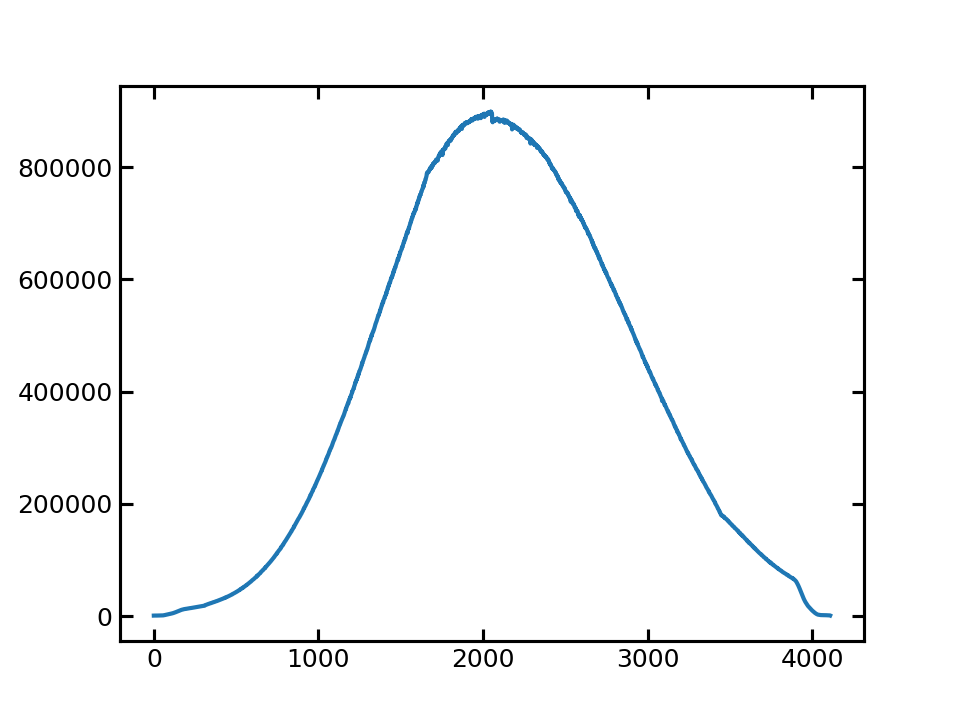

In [81]:
plt.close('all')
plt.plot(extracted_master[5])
plt.show()

In [ ]:
# _wave, _flux, hdr = veloce_reduction_tools.load_extracted_spectrum_fits(os.path.join(data_dir, file))

In [69]:
%matplotlib inline

False
Lower threshold at 40th percentile: 359.45597497991787


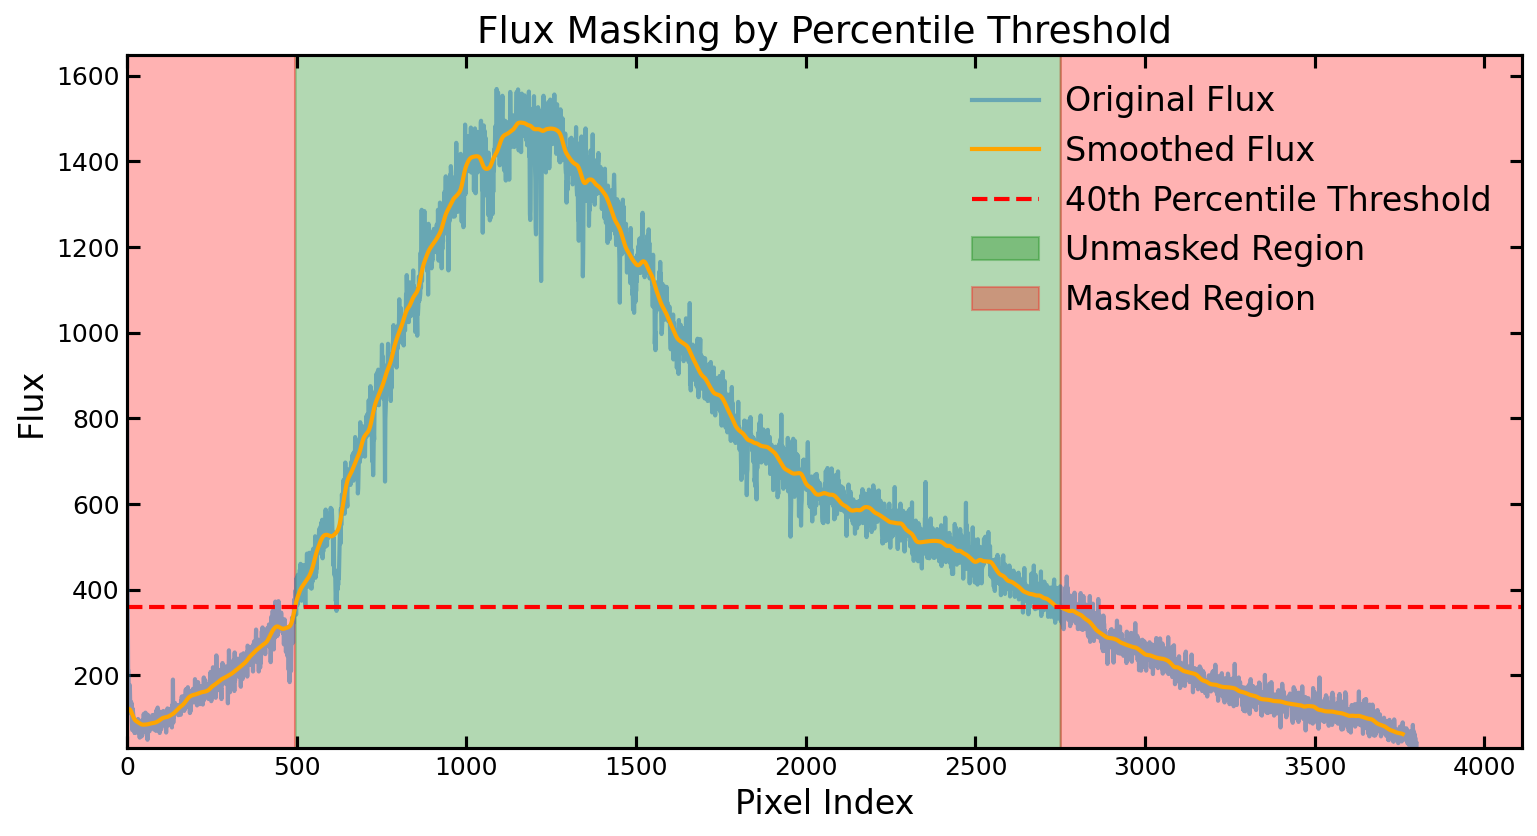

False
Lower threshold at 40th percentile: 854.5304118042518


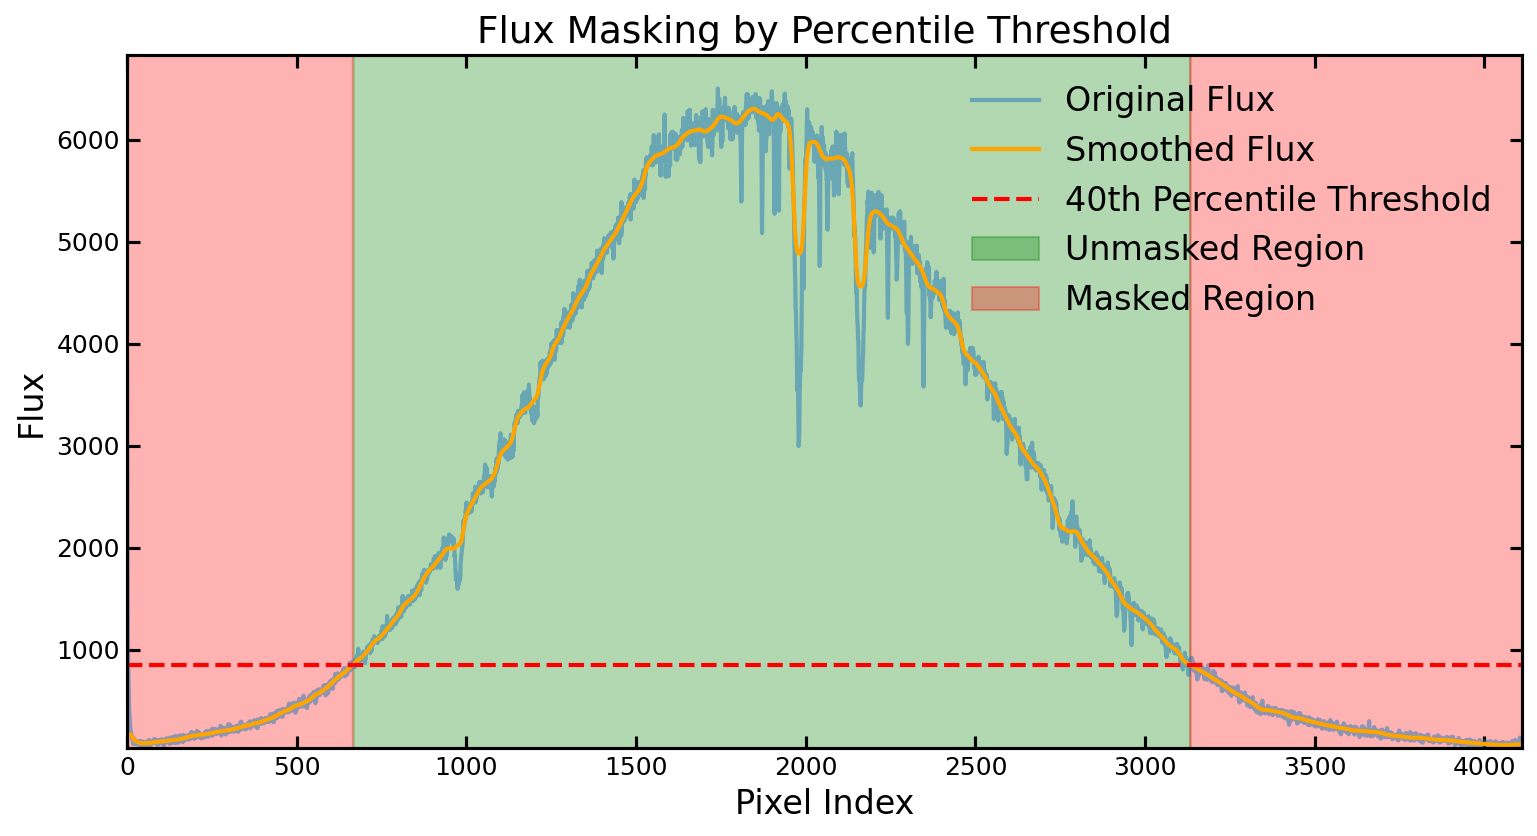

False
Lower threshold at 40th percentile: 1736.0806607985373


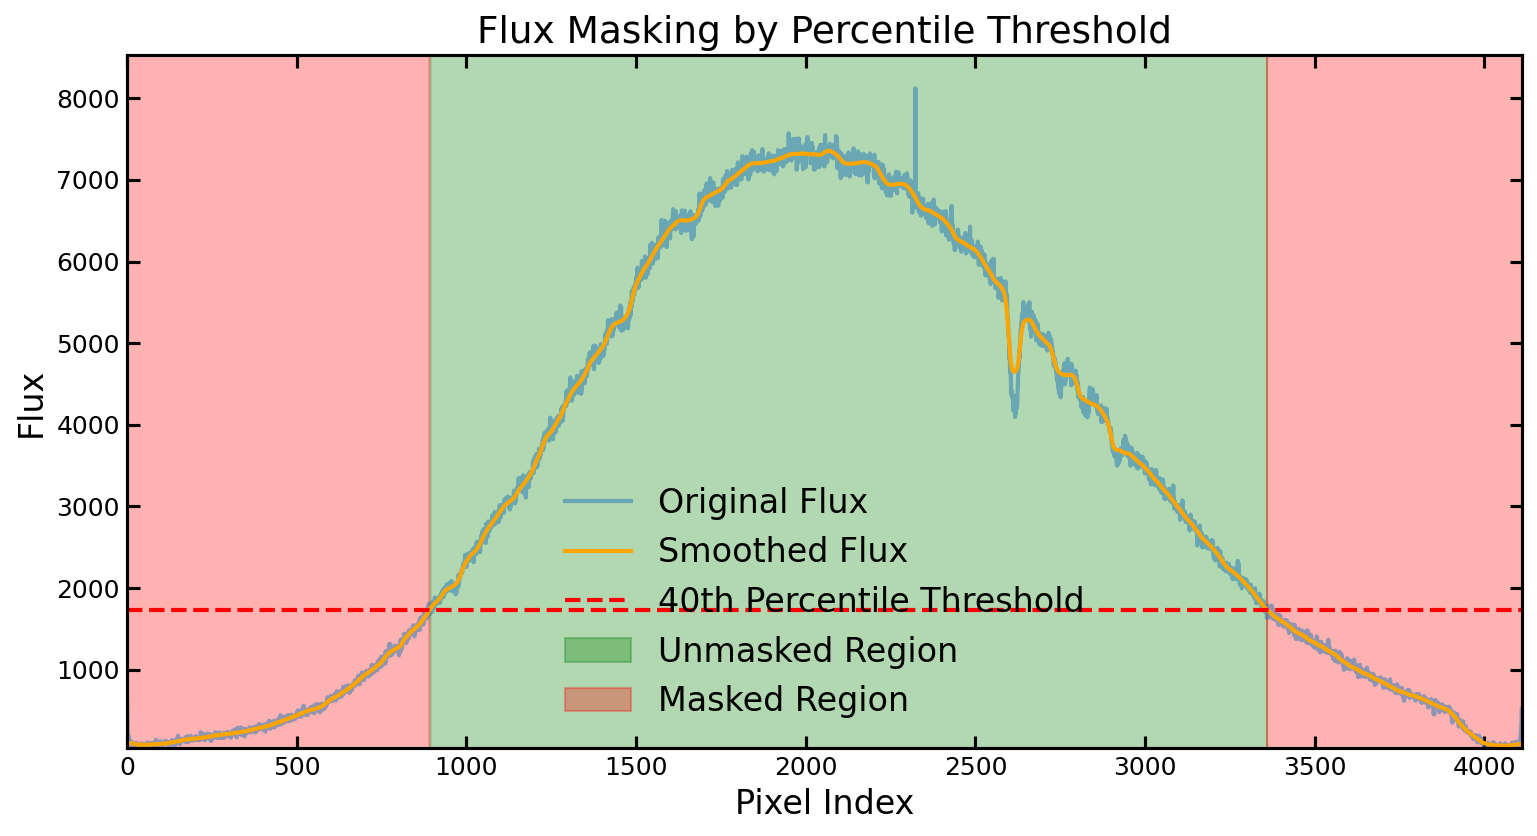

False
Lower threshold at 40th percentile: 1756.0764529145044


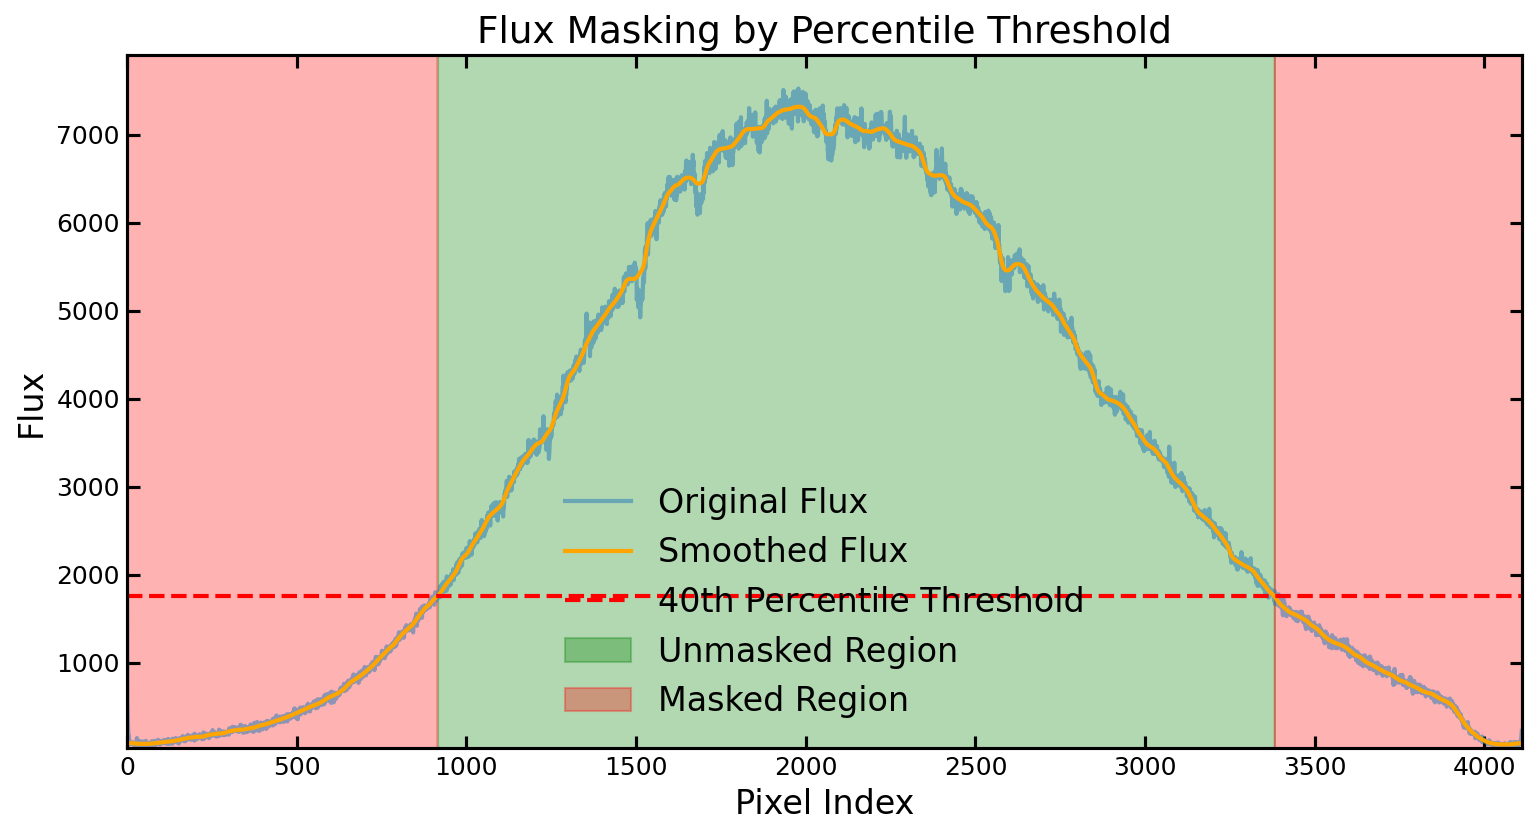

False
Lower threshold at 40th percentile: 1656.777843983233


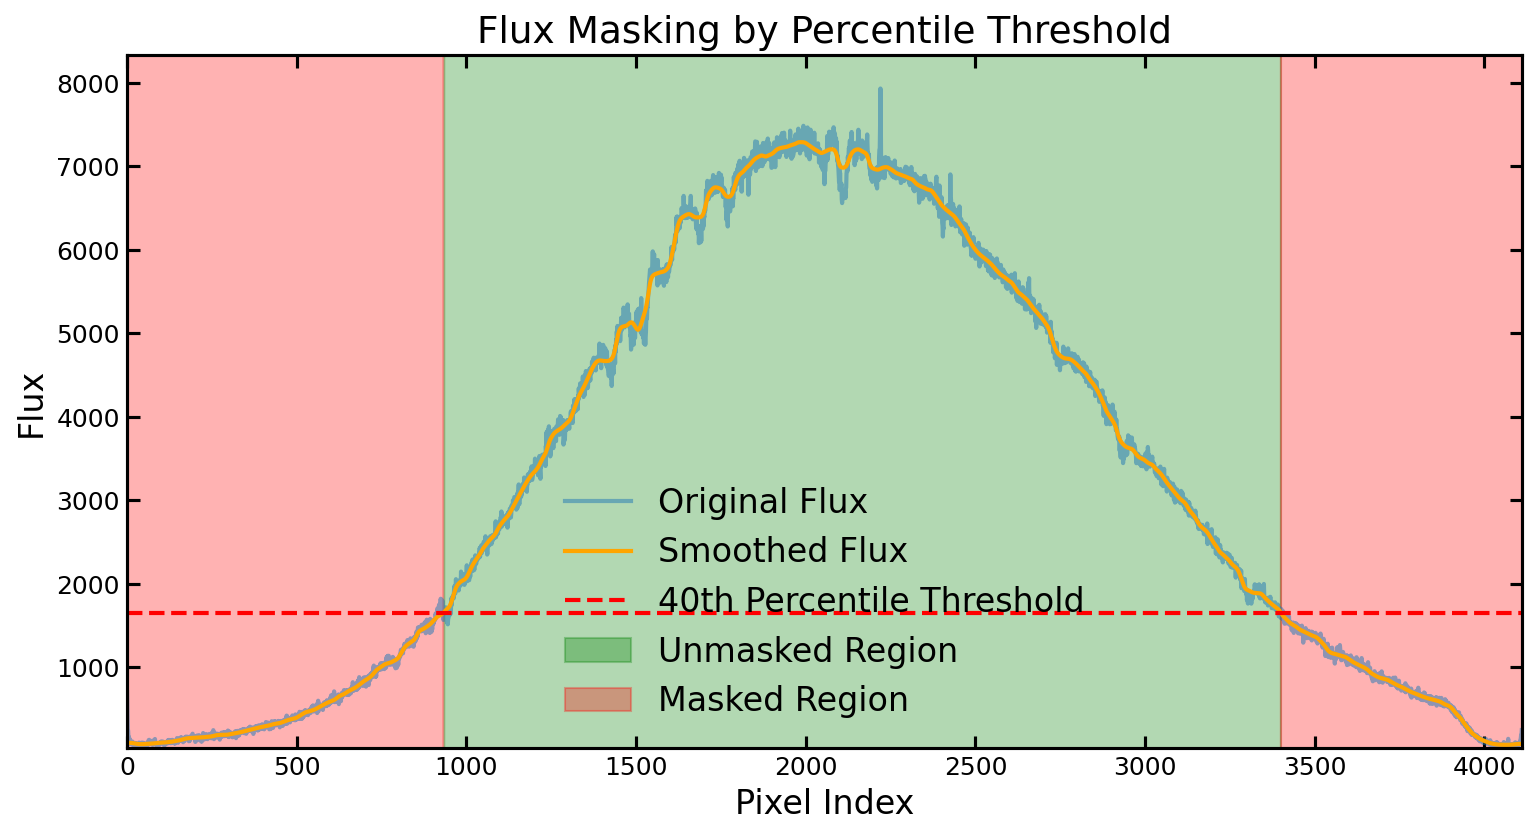

False
Lower threshold at 40th percentile: 1585.2807850858792


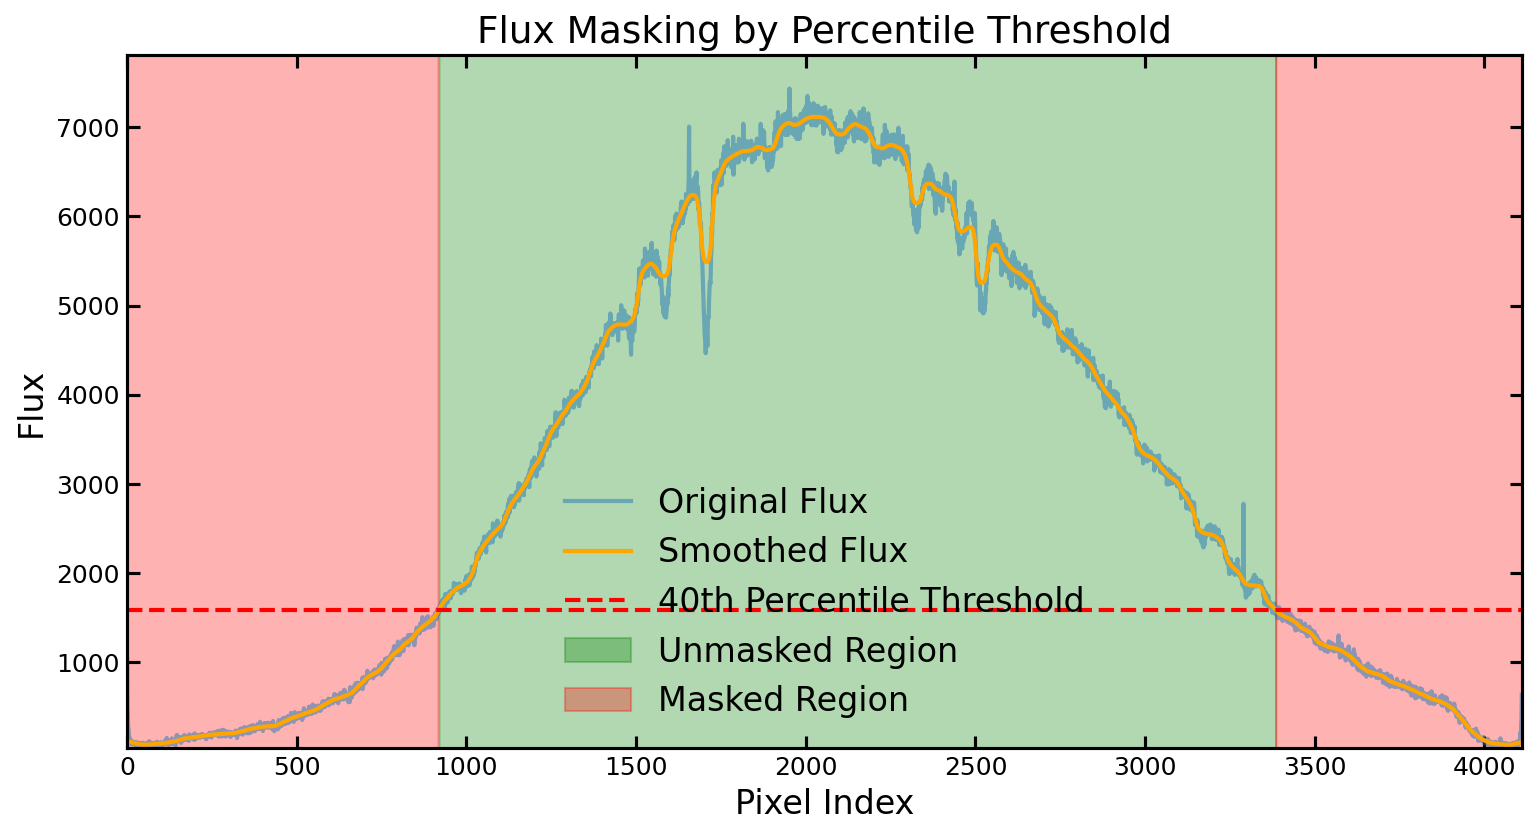

False
Lower threshold at 40th percentile: 1512.9993787448627


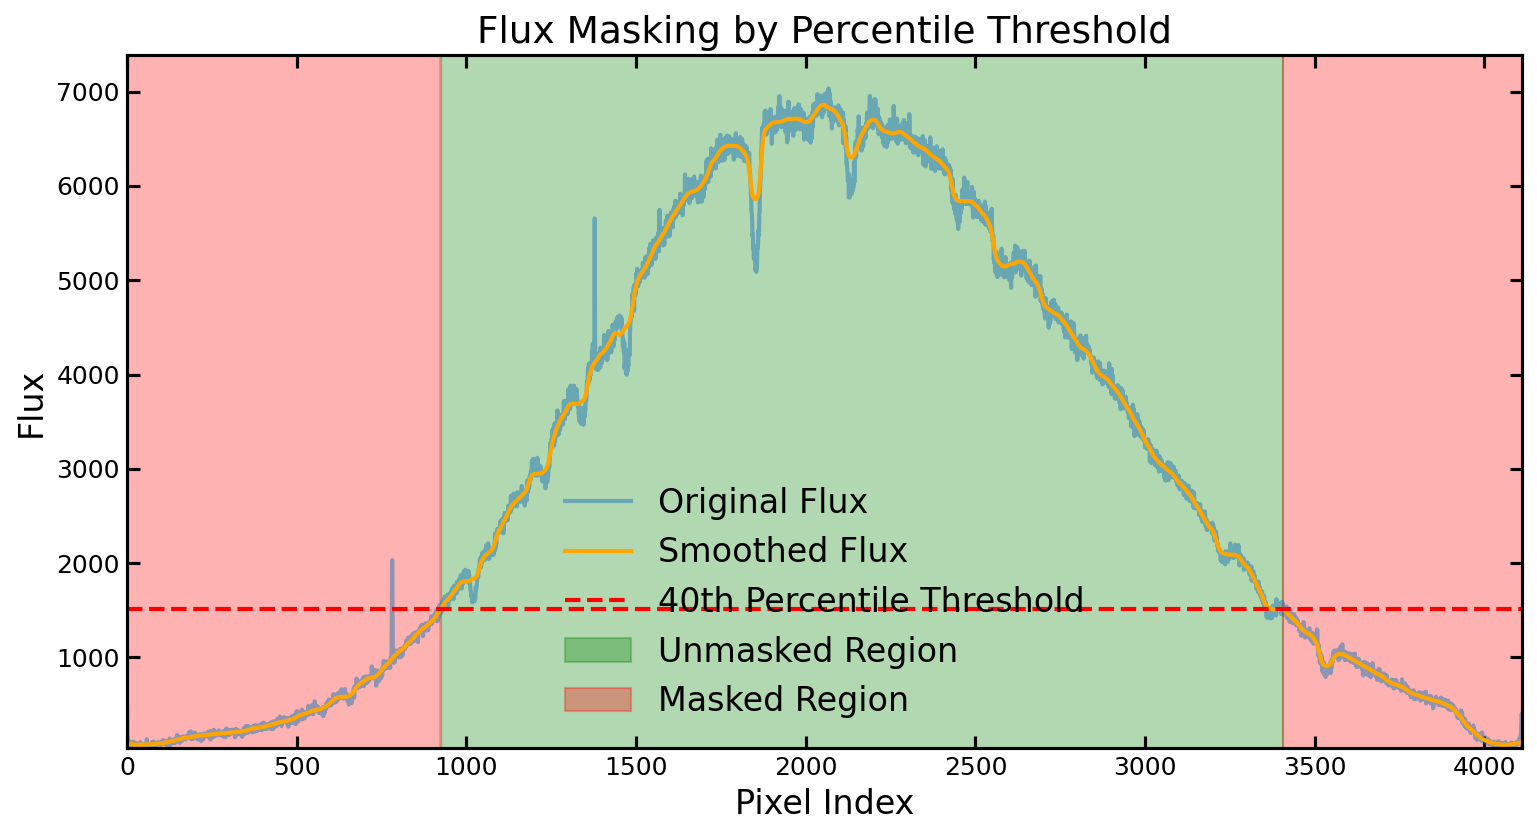

False
Lower threshold at 40th percentile: 1460.2007049123893


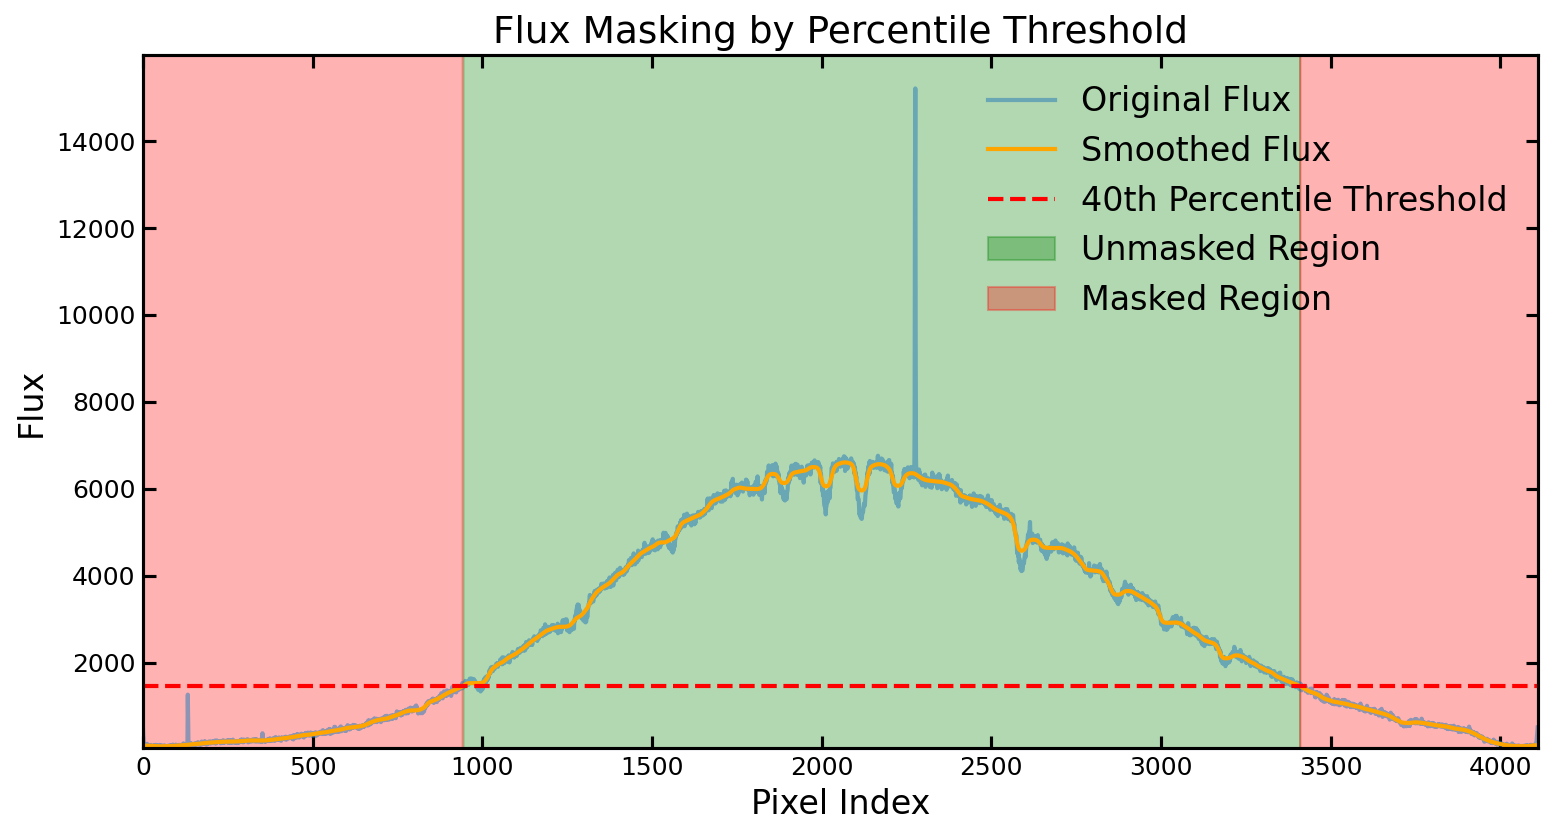

False
Lower threshold at 40th percentile: 1377.5263402185242


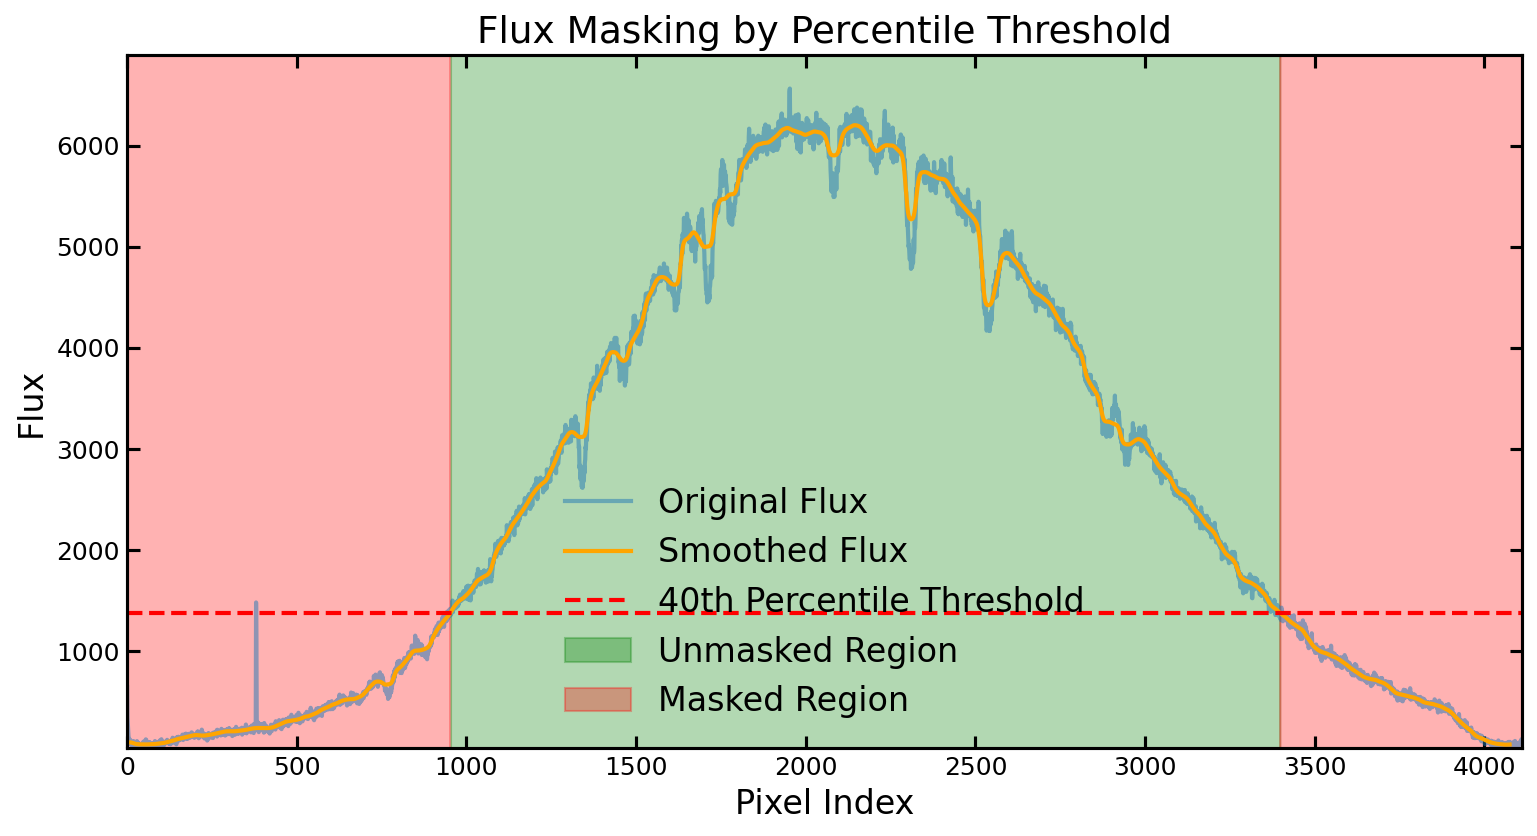

False
Lower threshold at 40th percentile: 1179.539662247411


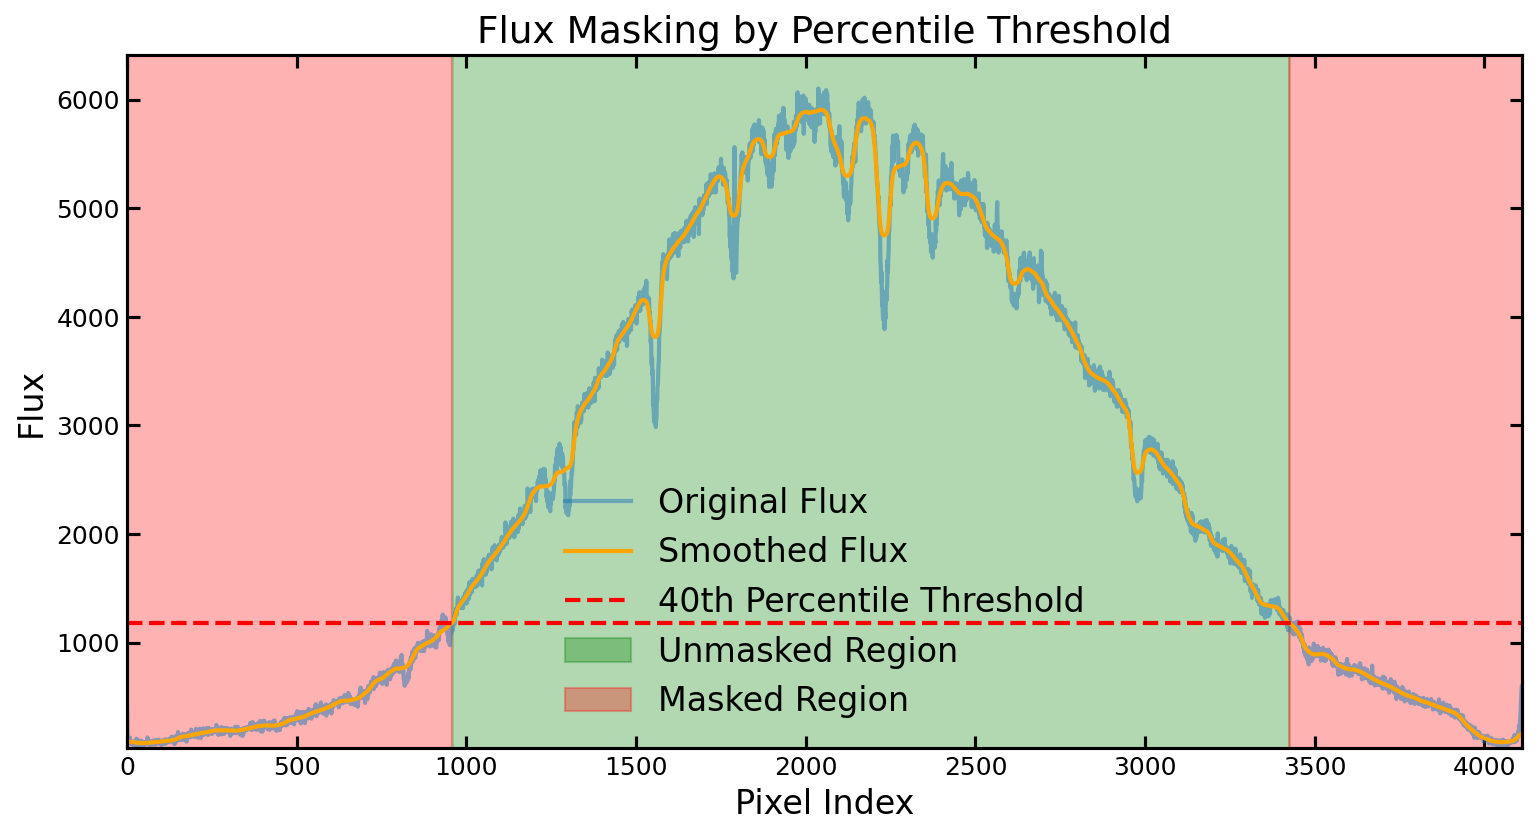

False
Lower threshold at 40th percentile: 1126.5738609303714


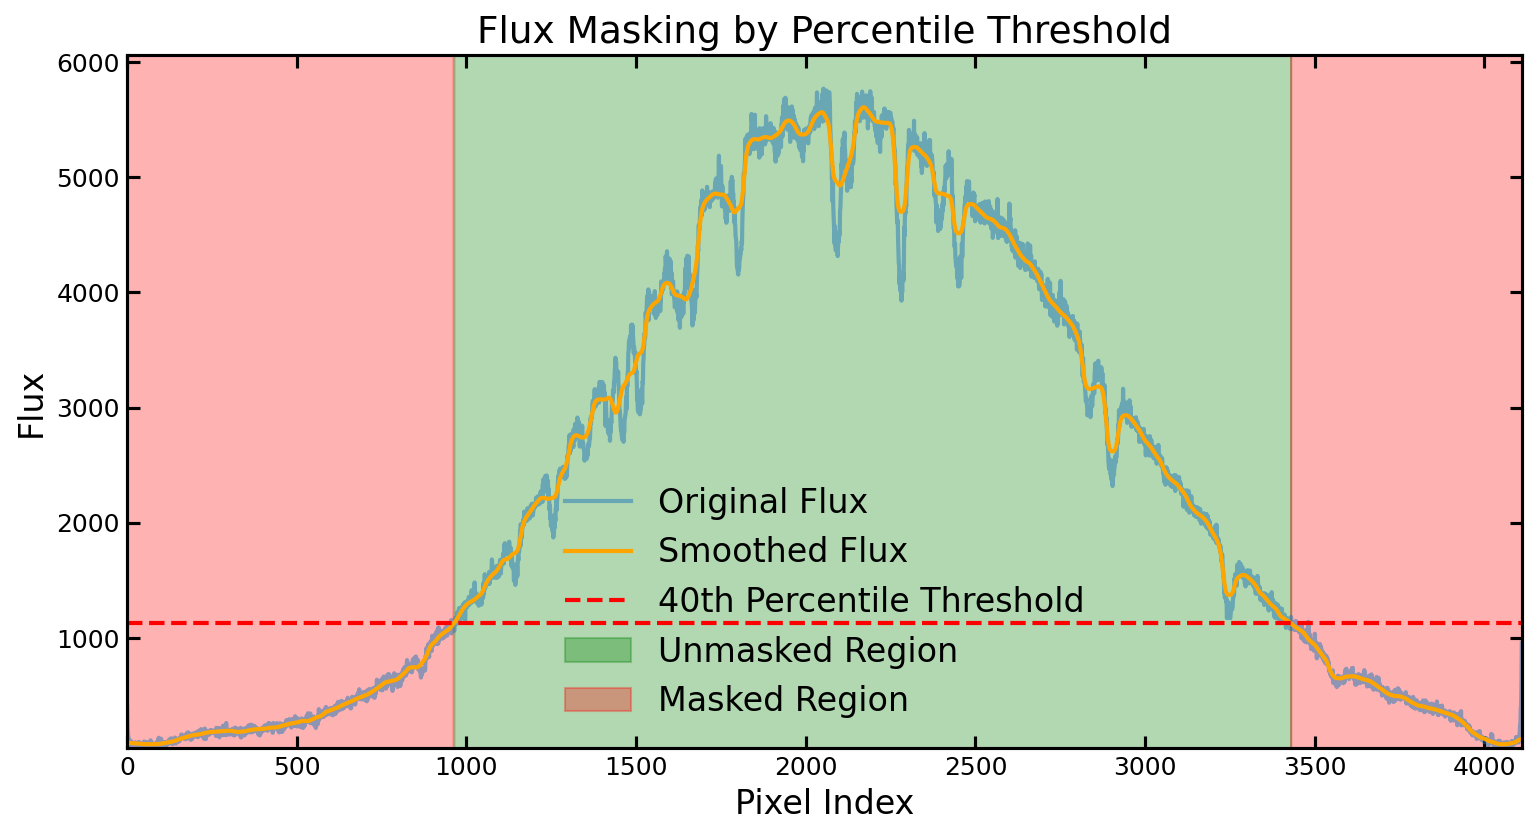

False
Lower threshold at 40th percentile: 984.7717868392884


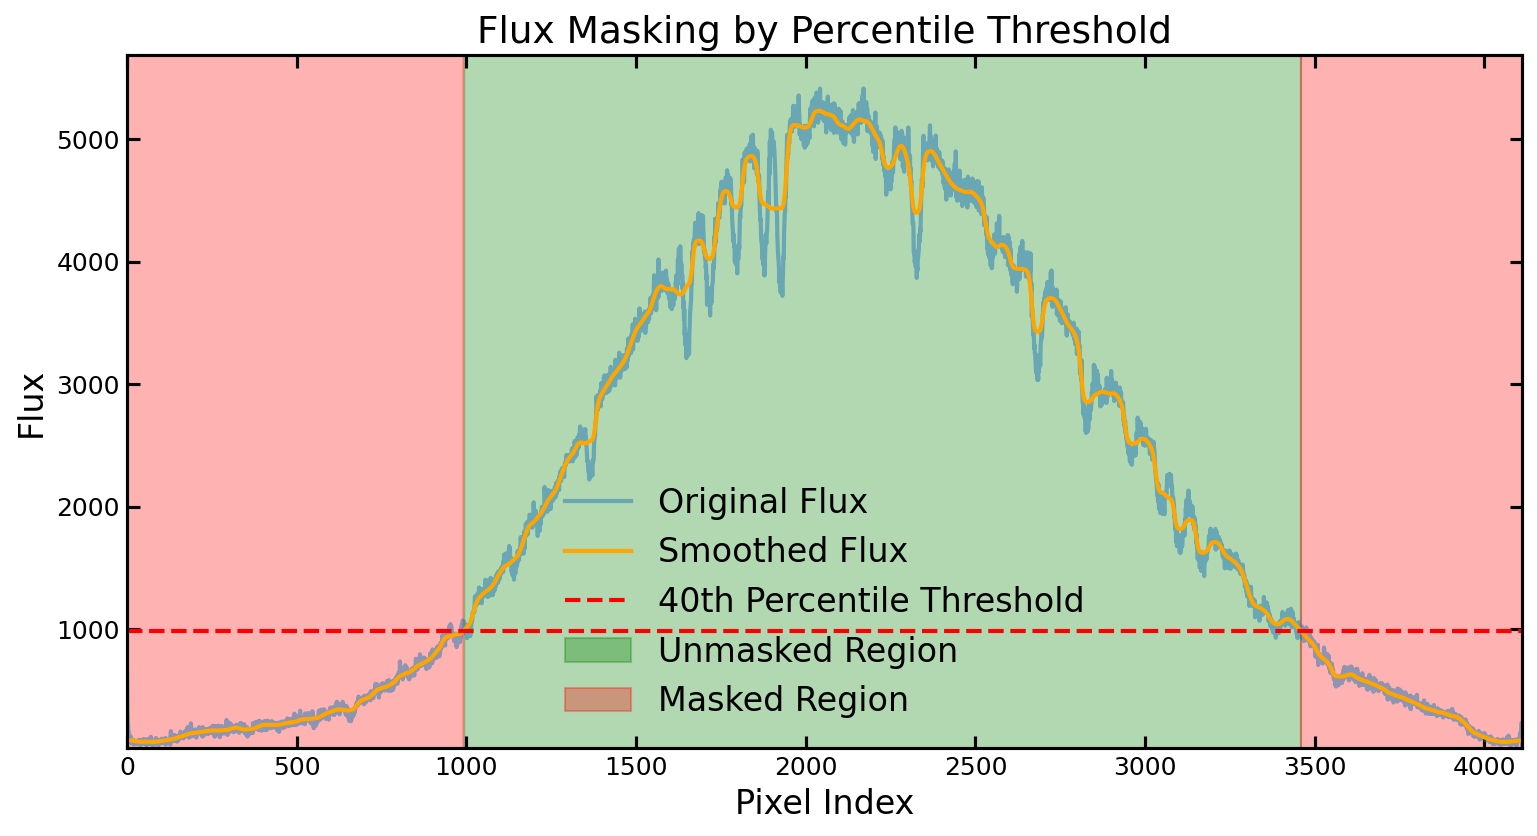

False
Lower threshold at 40th percentile: 860.4649040310507


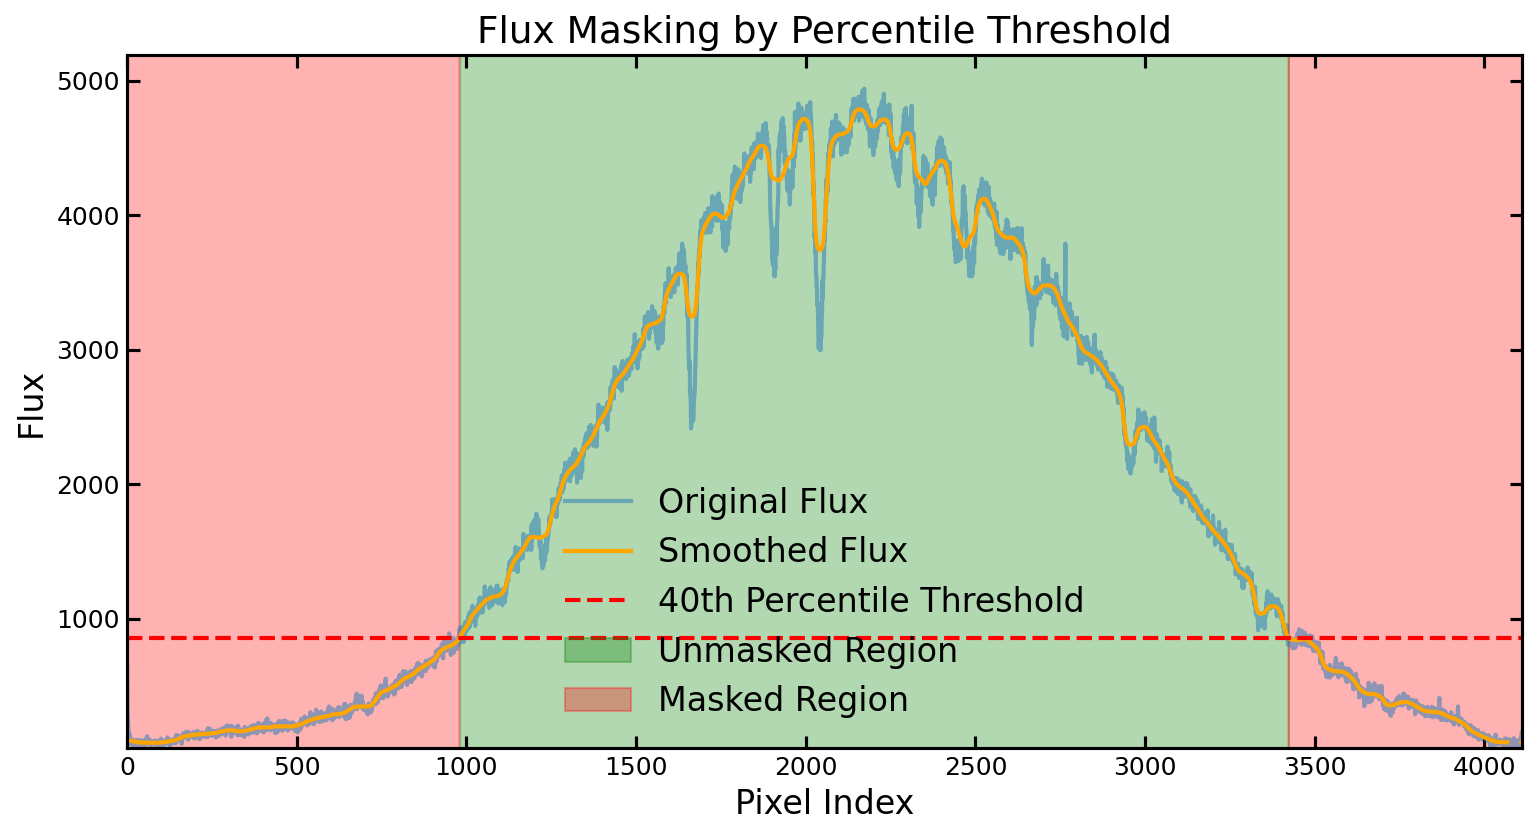

False
Lower threshold at 40th percentile: 830.9492018218202


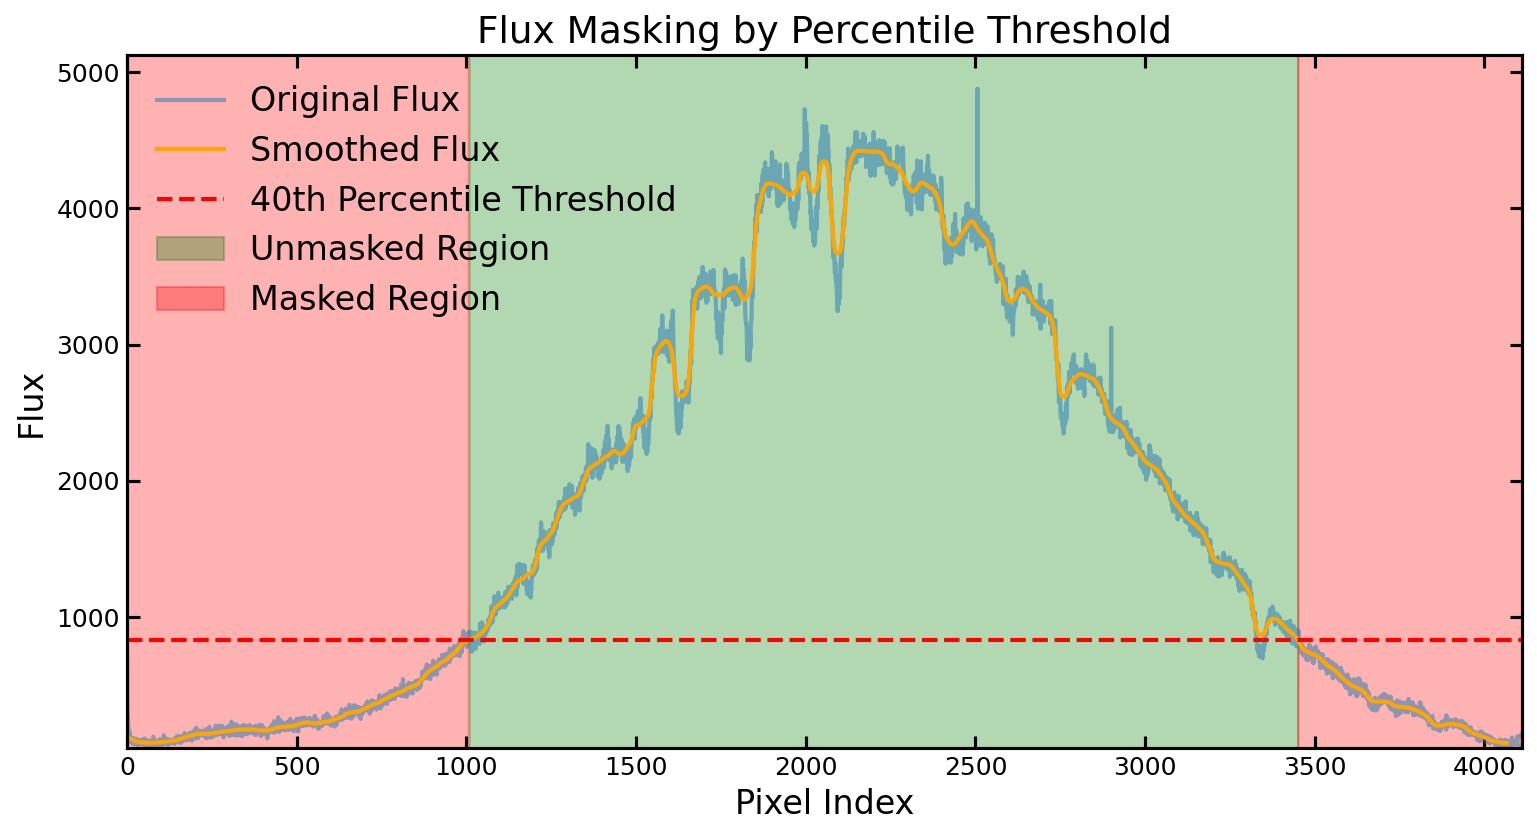

False
Lower threshold at 40th percentile: 554.6933849256911


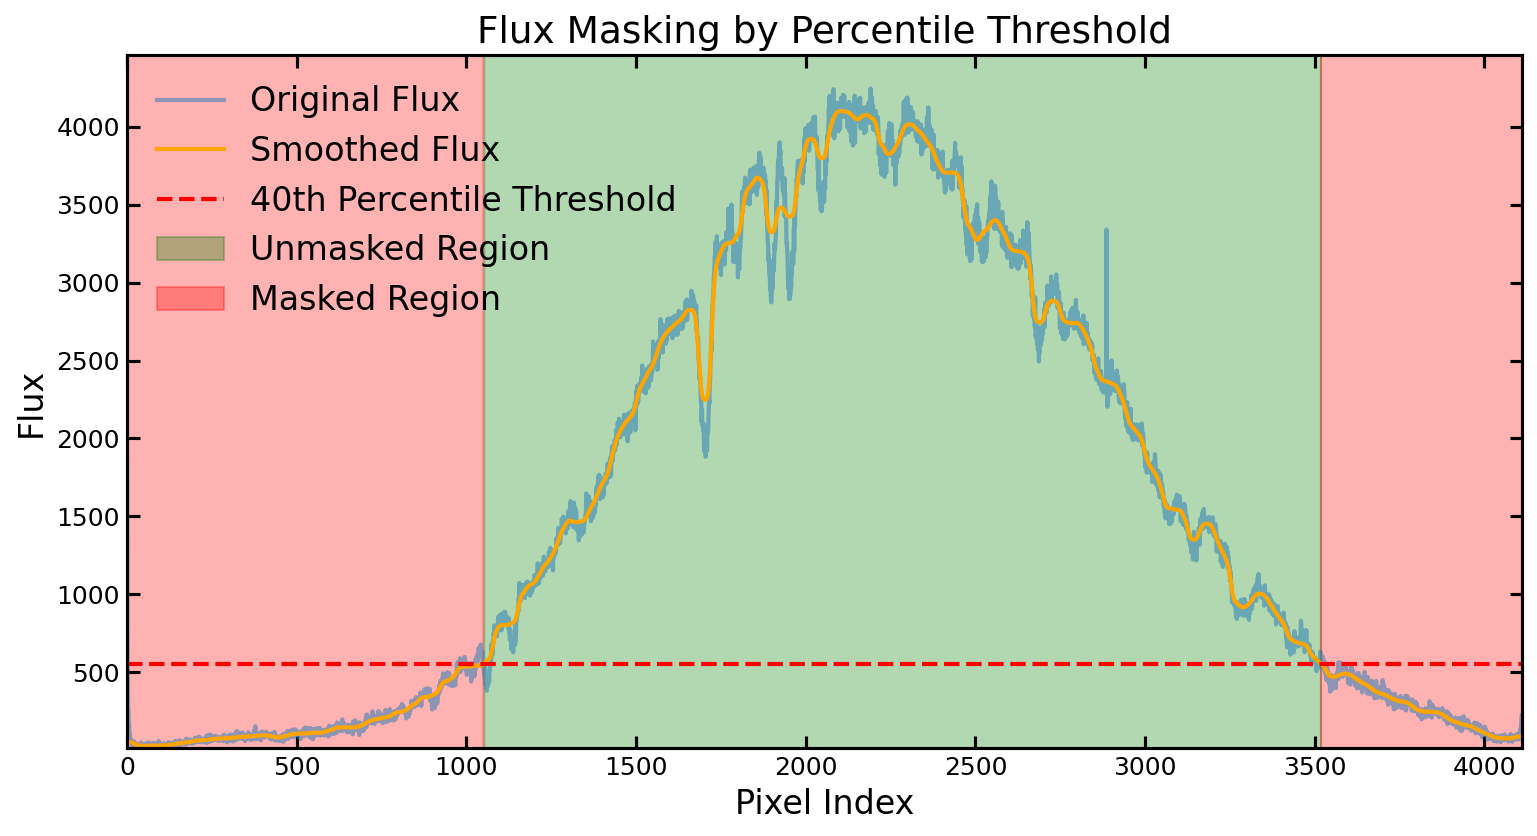

False
Lower threshold at 40th percentile: 561.3066095356054


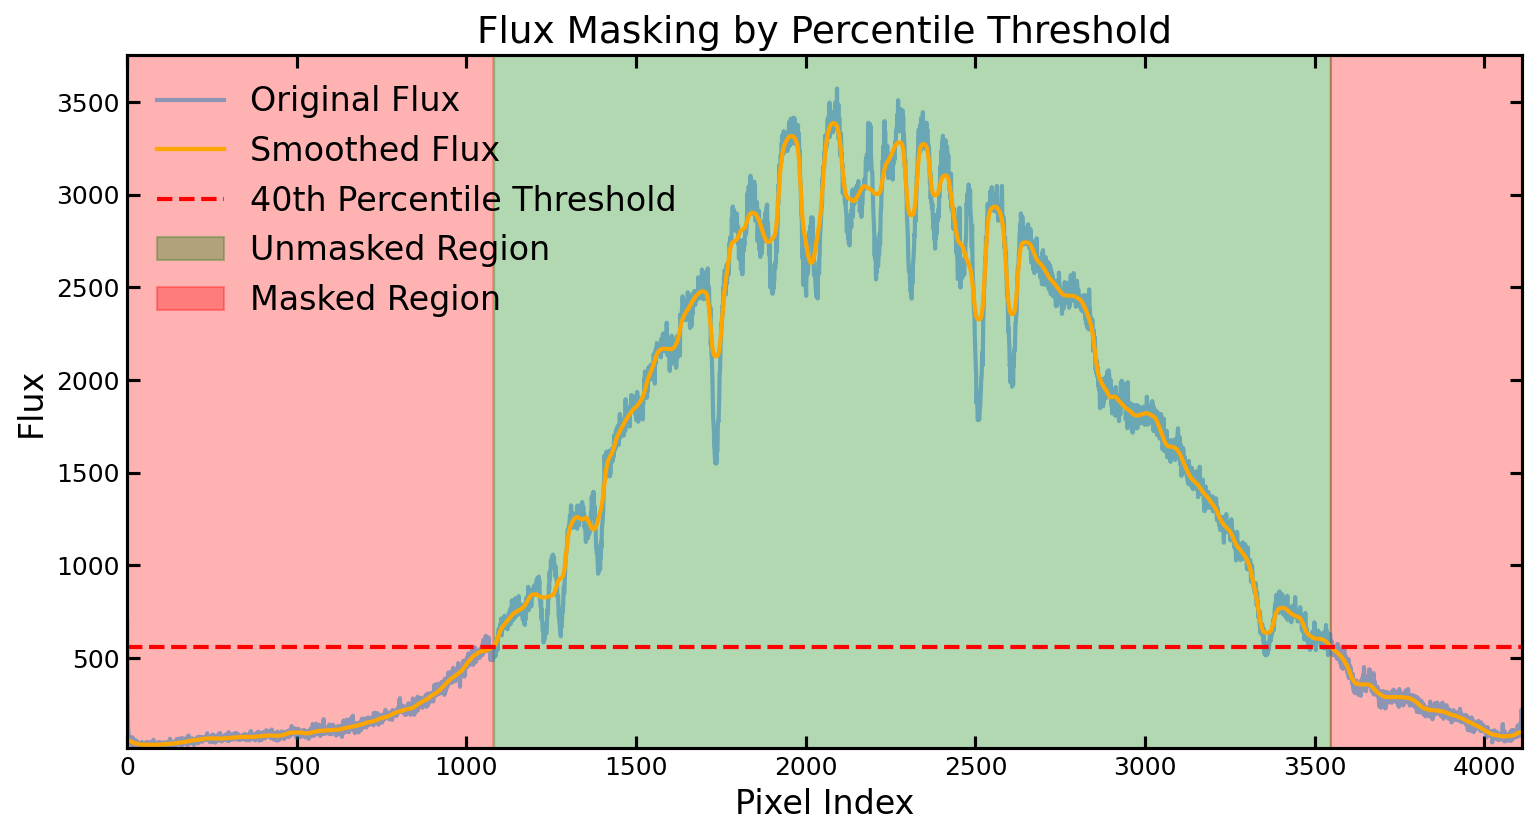

False
Lower threshold at 40th percentile: 475.21200492652764


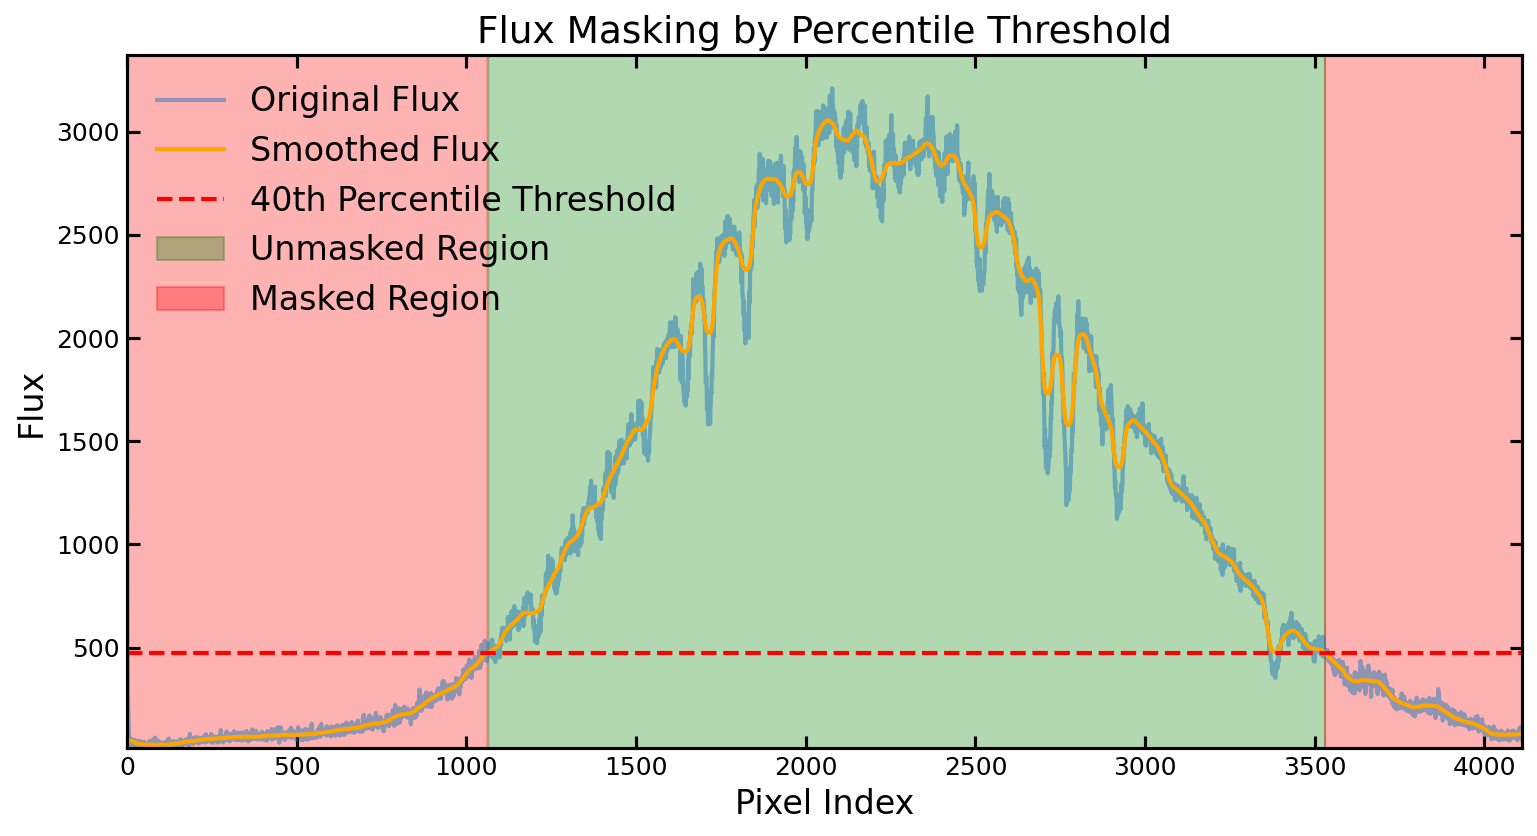

False
Lower threshold at 40th percentile: 375.54463436851046


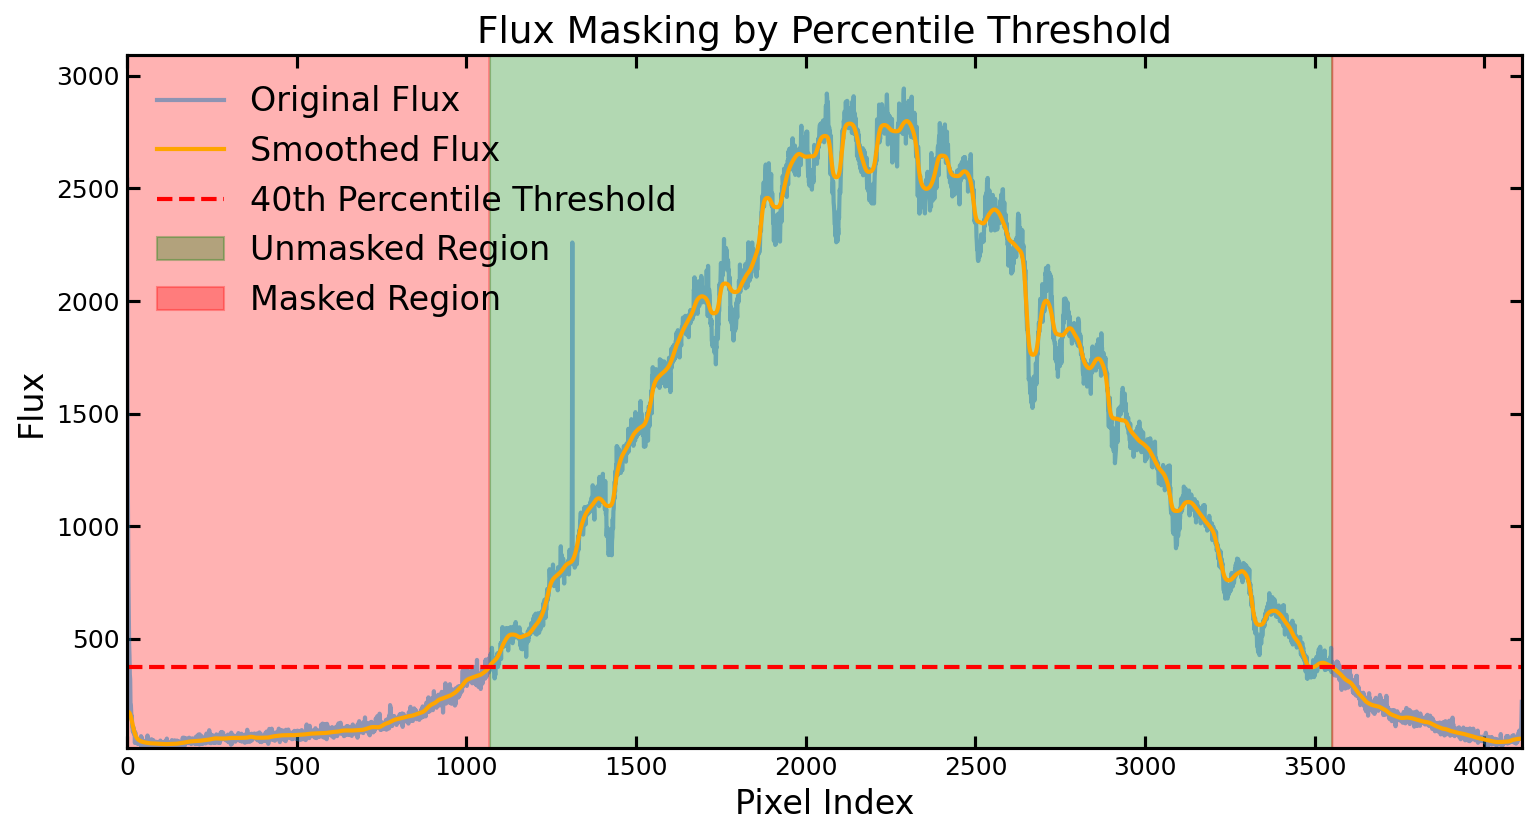

False
Lower threshold at 40th percentile: 360.7179139792793


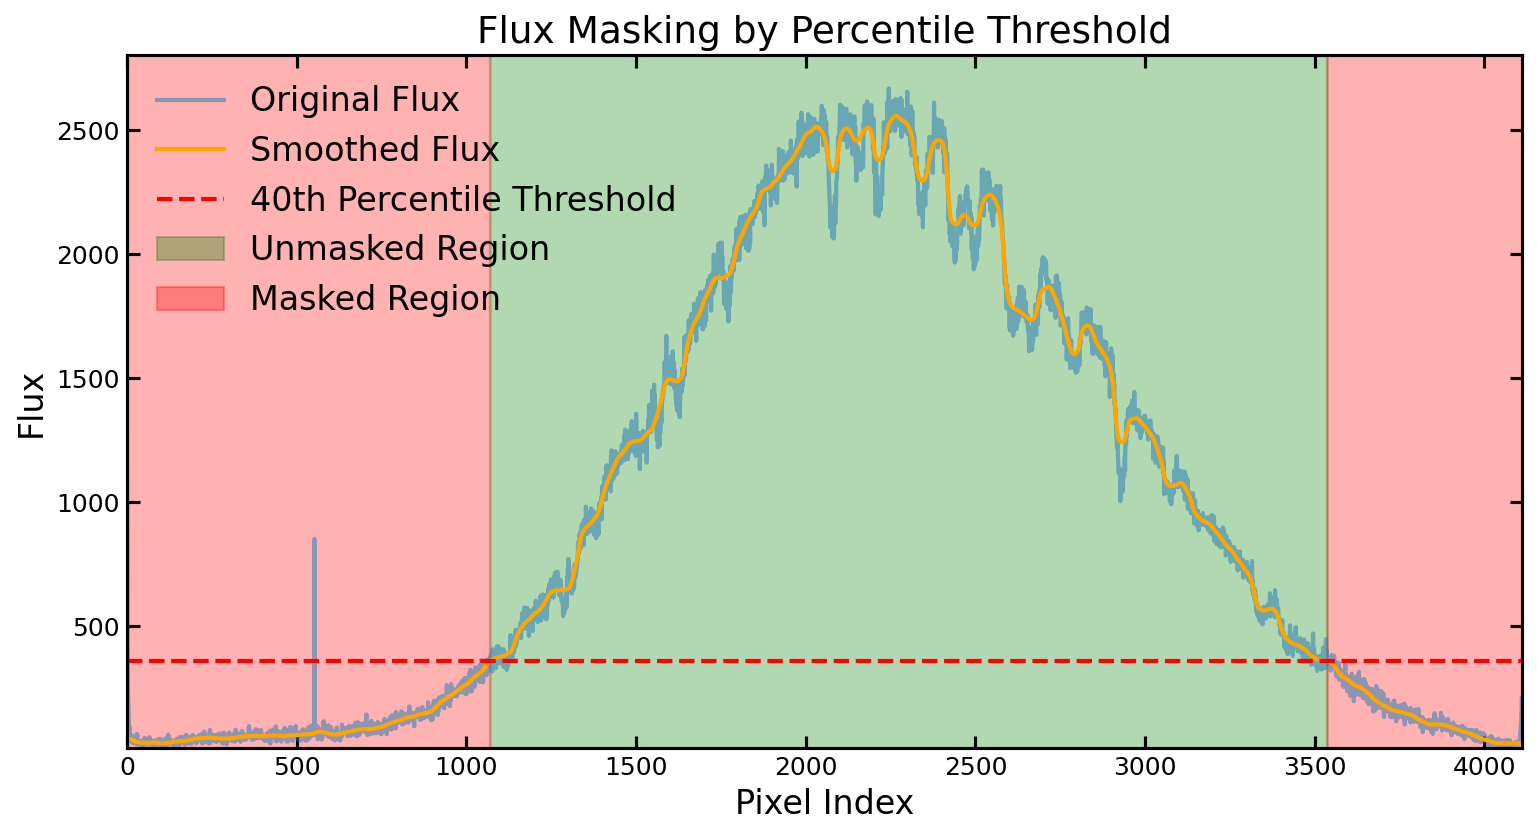

False
Lower threshold at 40th percentile: 320.8068939154939


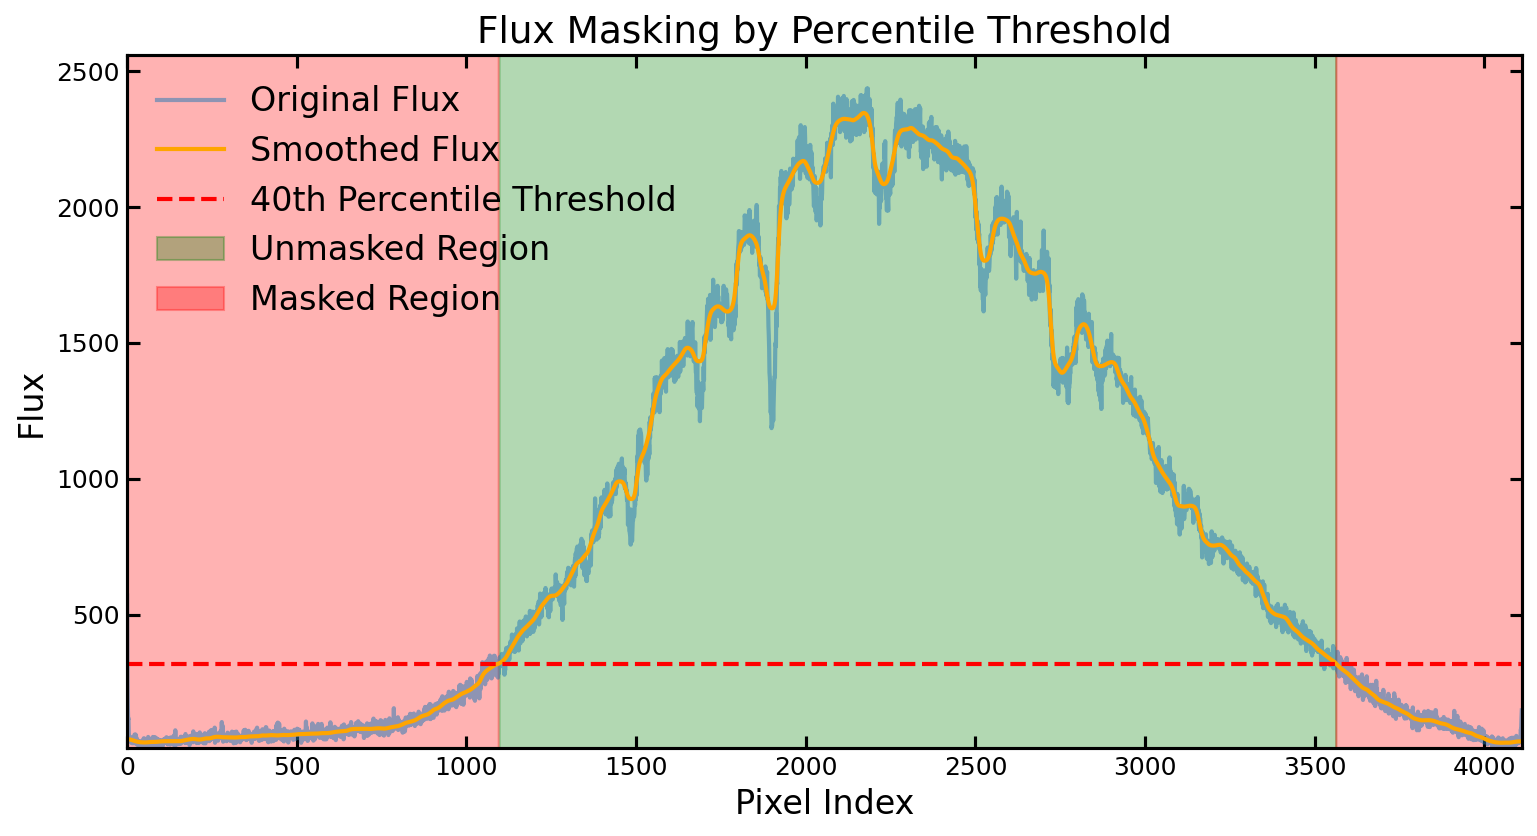

False
Lower threshold at 40th percentile: 268.46997389347047


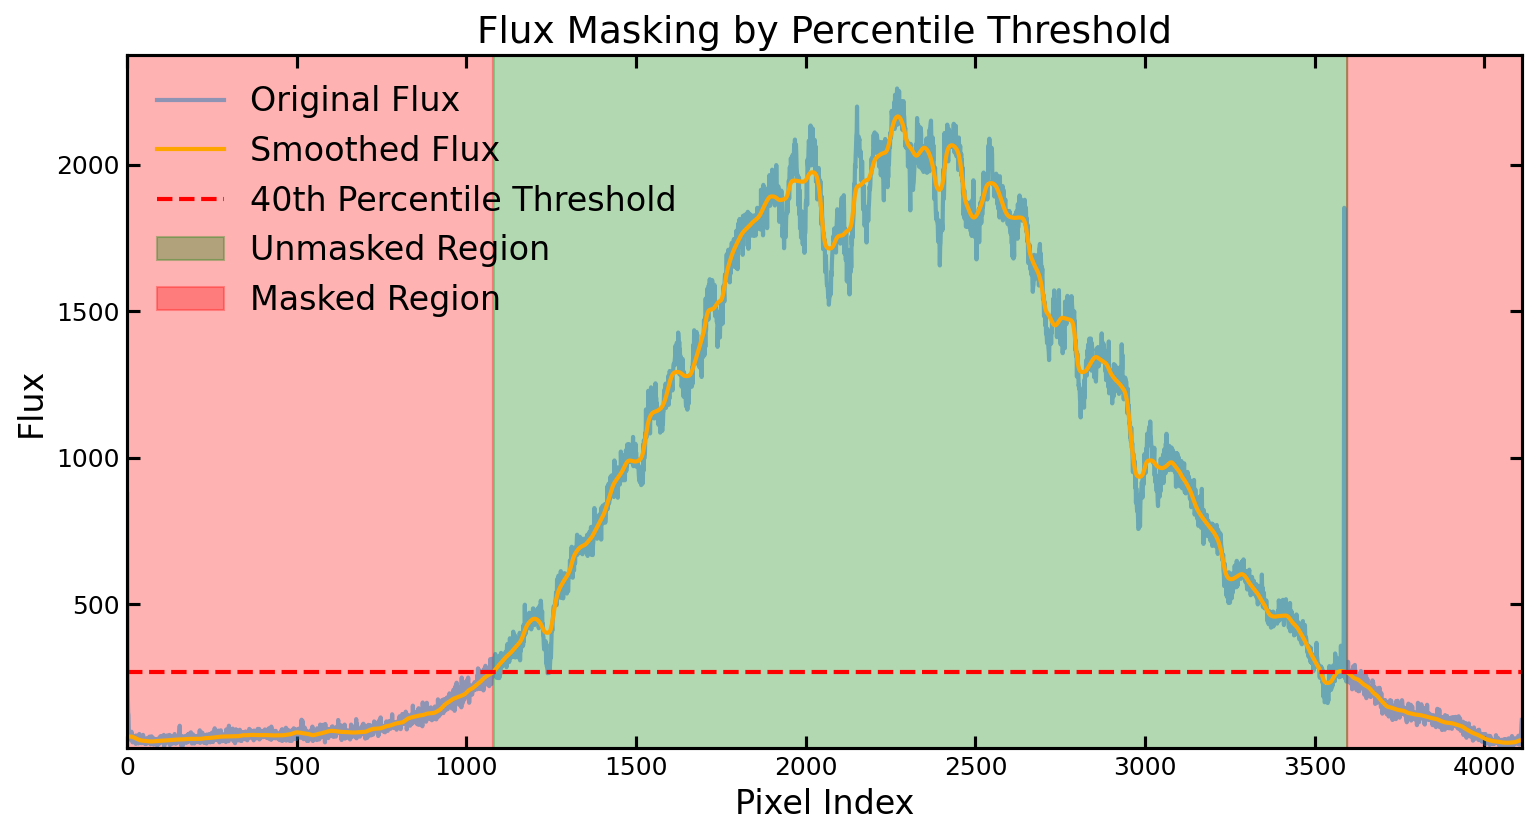

False
Lower threshold at 40th percentile: 274.47778813908616


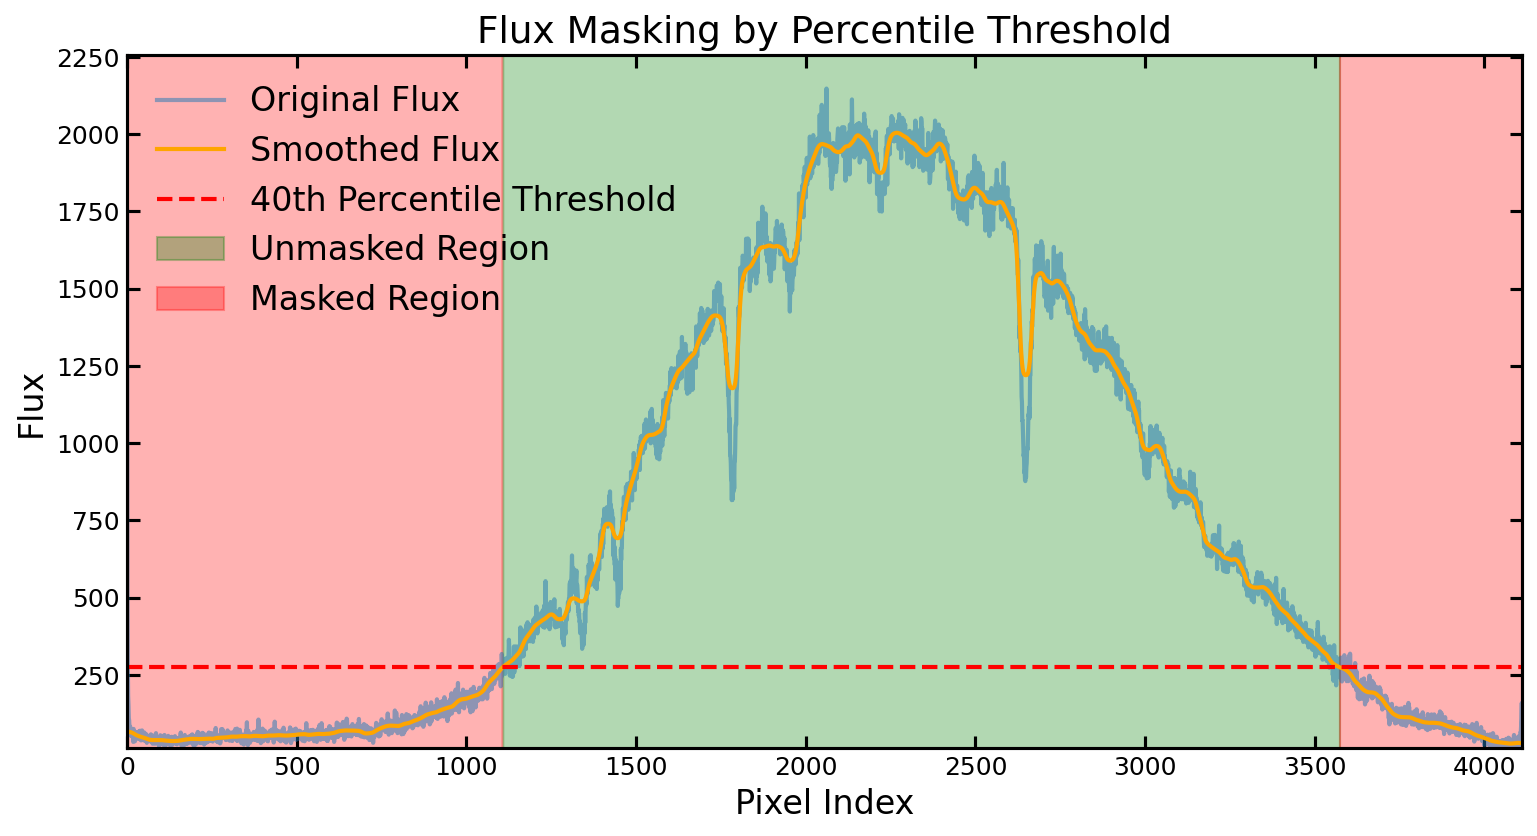

False
Lower threshold at 40th percentile: 231.0096640604707


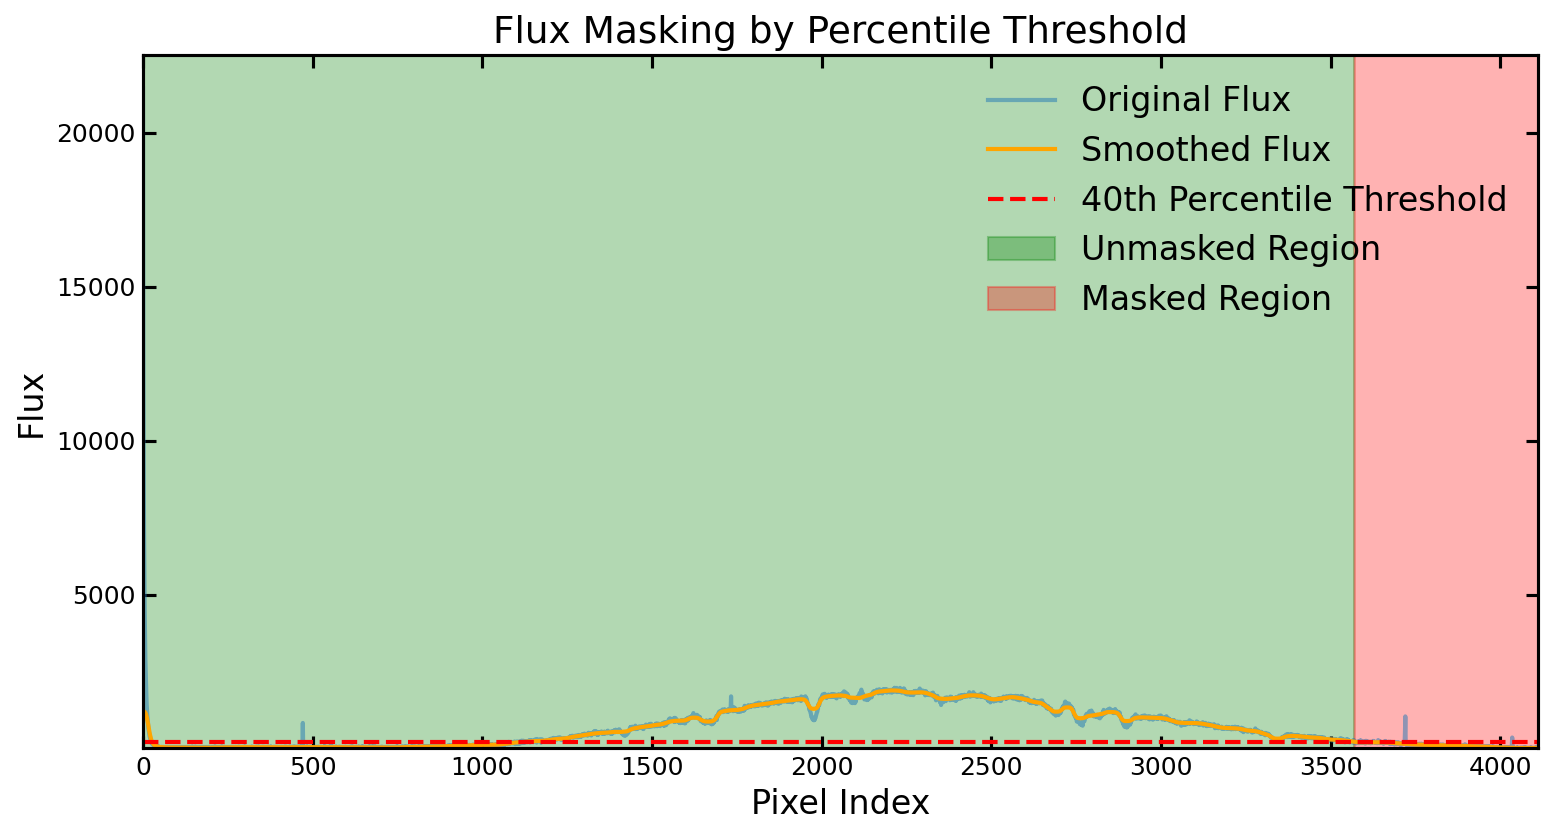

False
Lower threshold at 40th percentile: 217.62076793590455


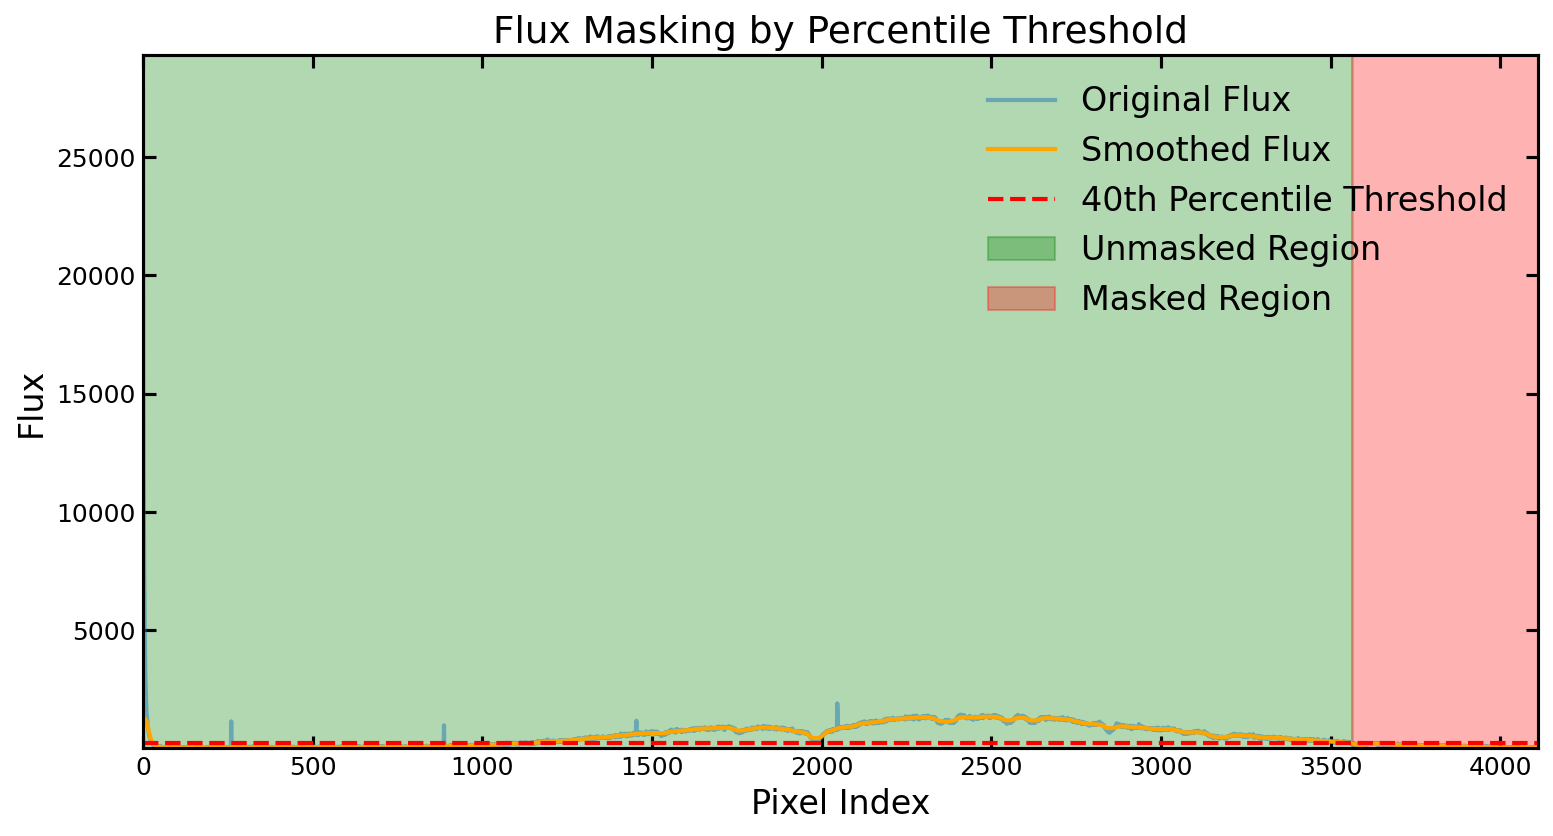

False
Lower threshold at 40th percentile: 153.43734278003612


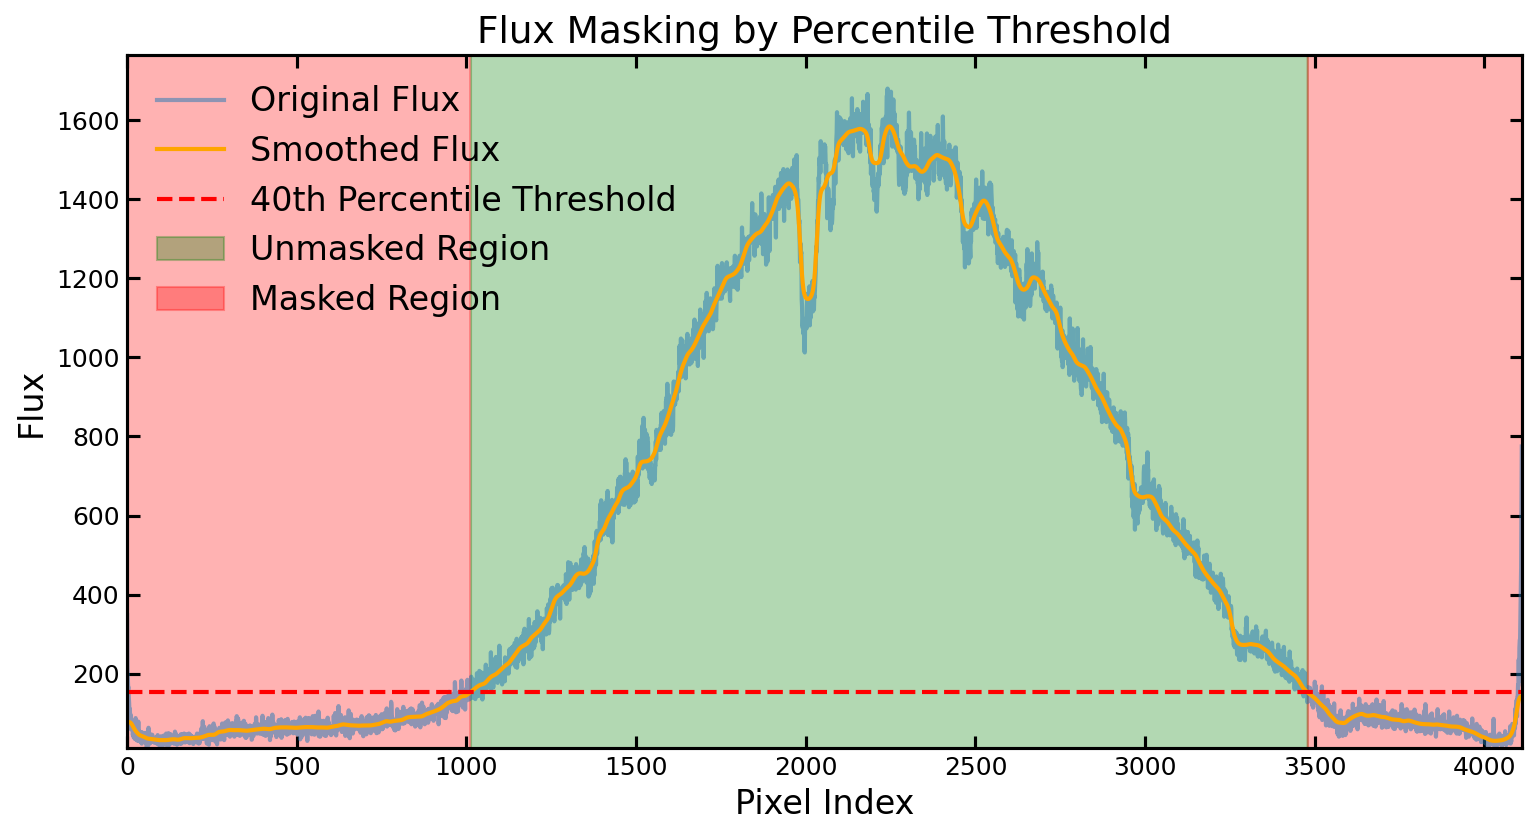

False
Lower threshold at 40th percentile: 194.69631219937736


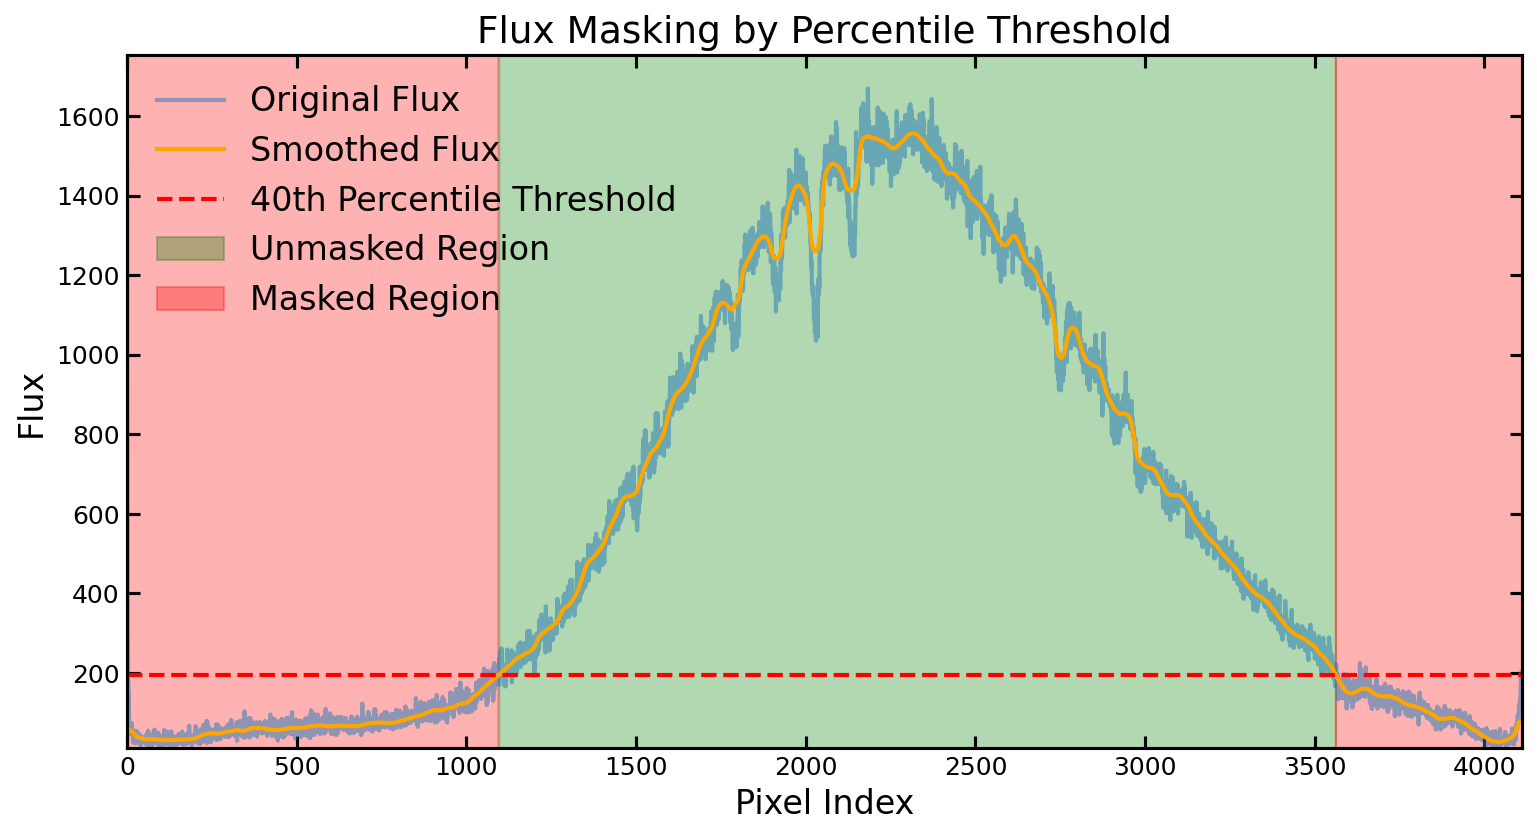

False
Lower threshold at 40th percentile: 185.16876382168886


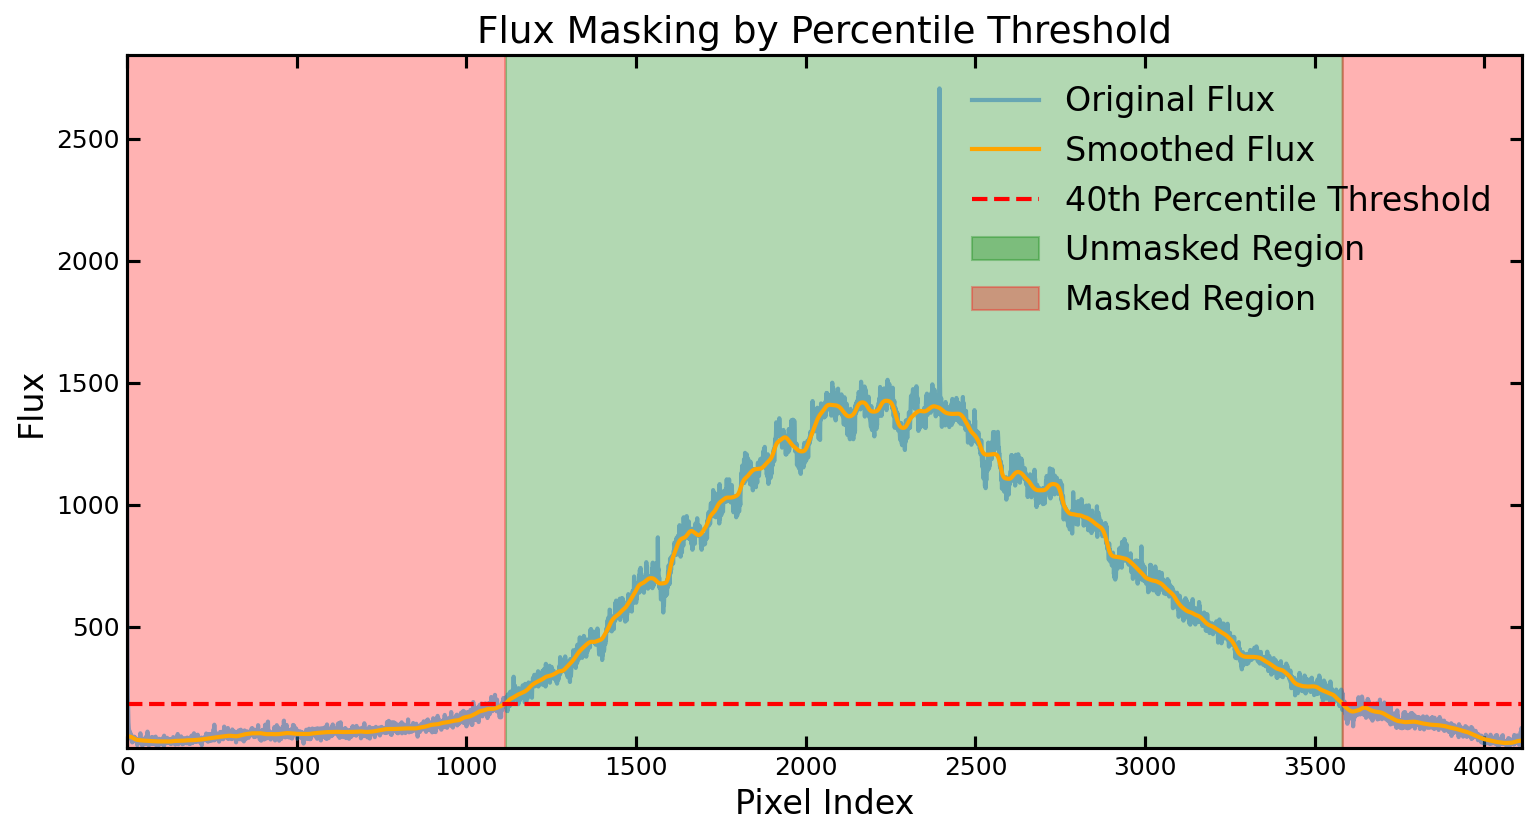

False
Lower threshold at 40th percentile: 180.4312624300583


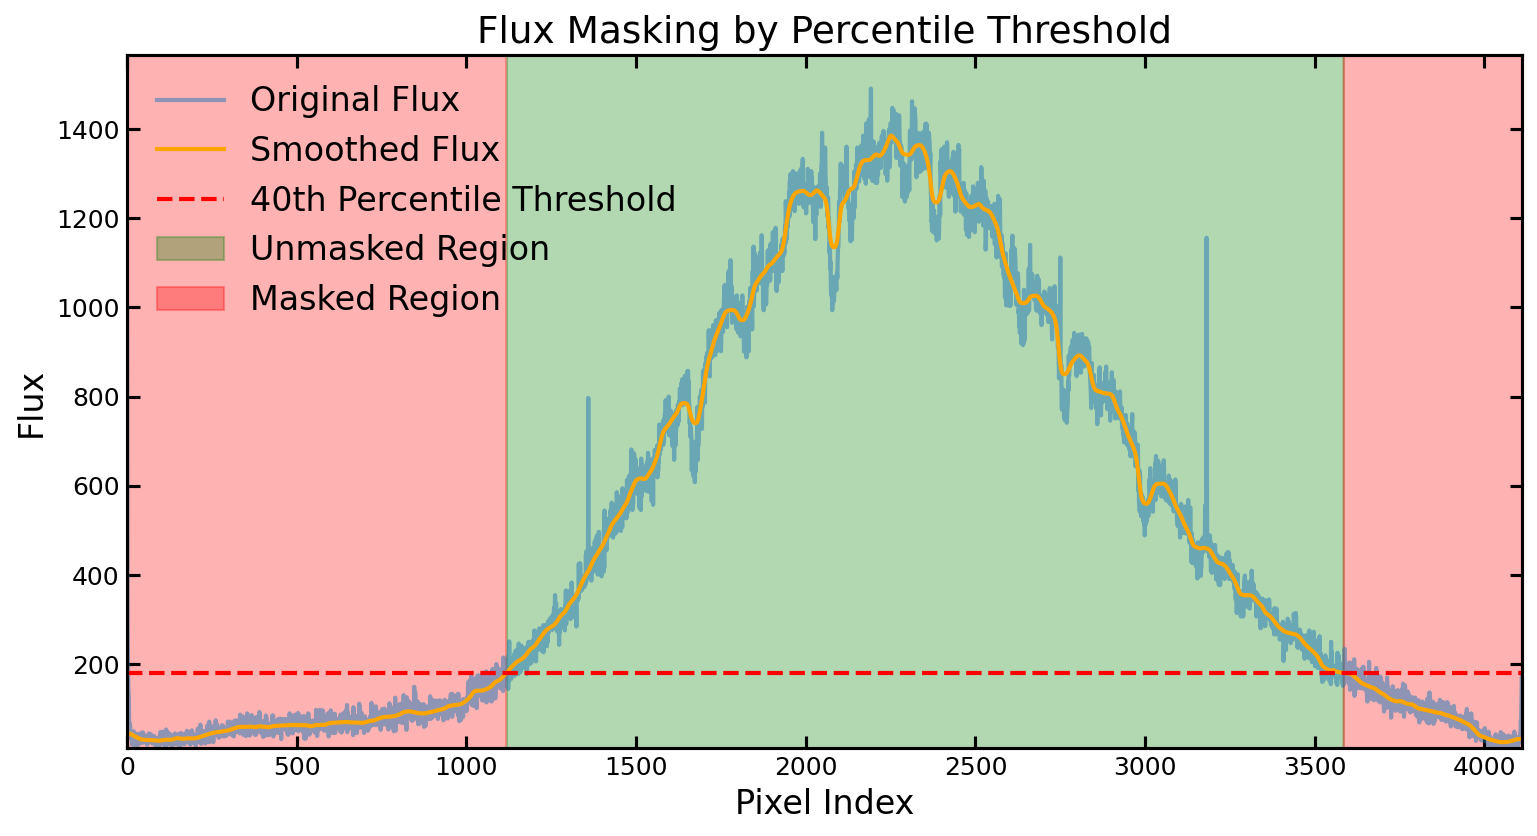

False
Lower threshold at 40th percentile: 171.06696861641402


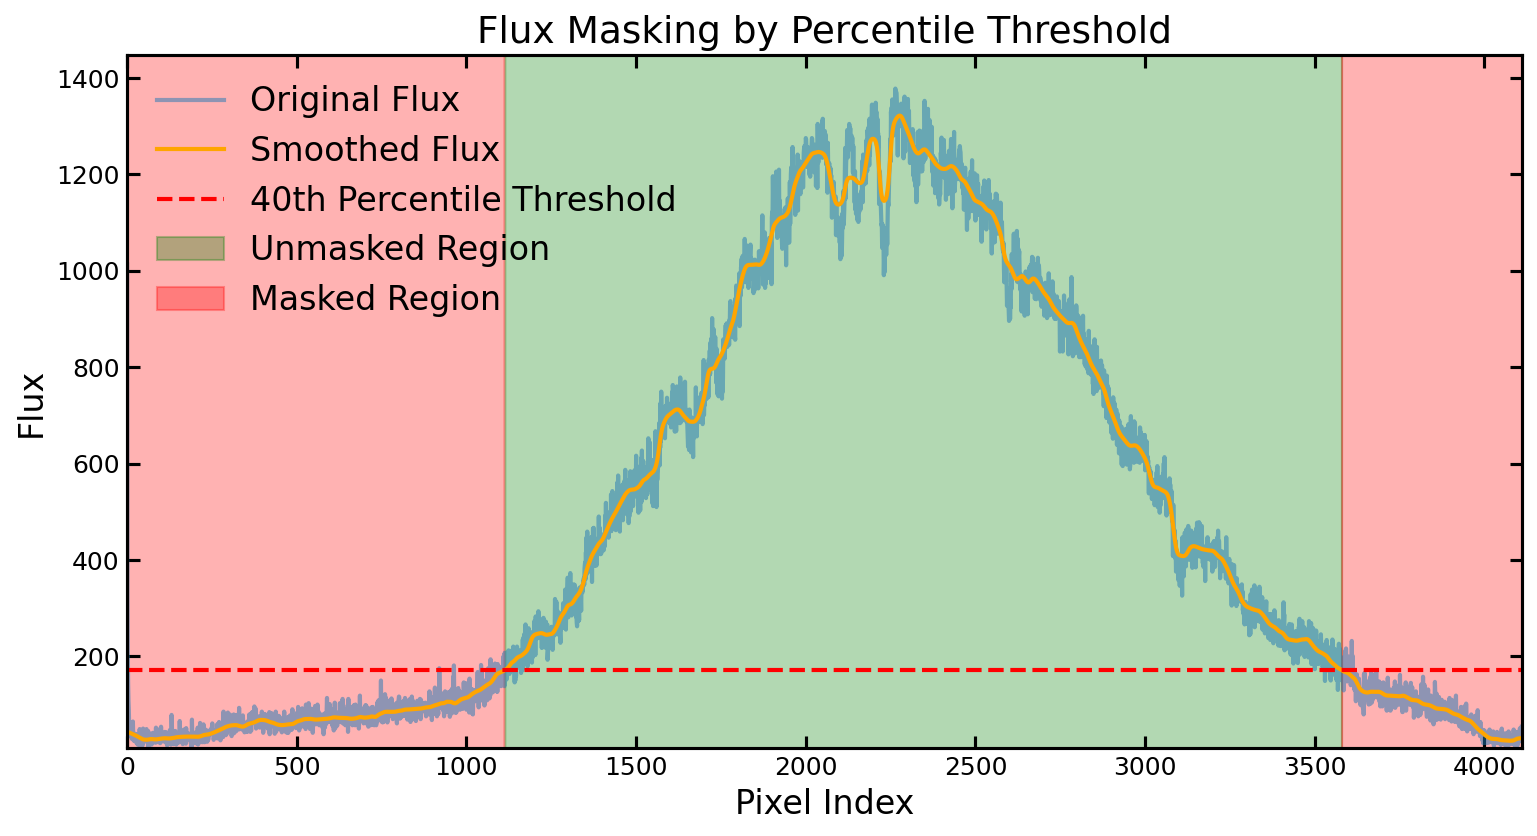

False
Lower threshold at 40th percentile: 163.71948340946702


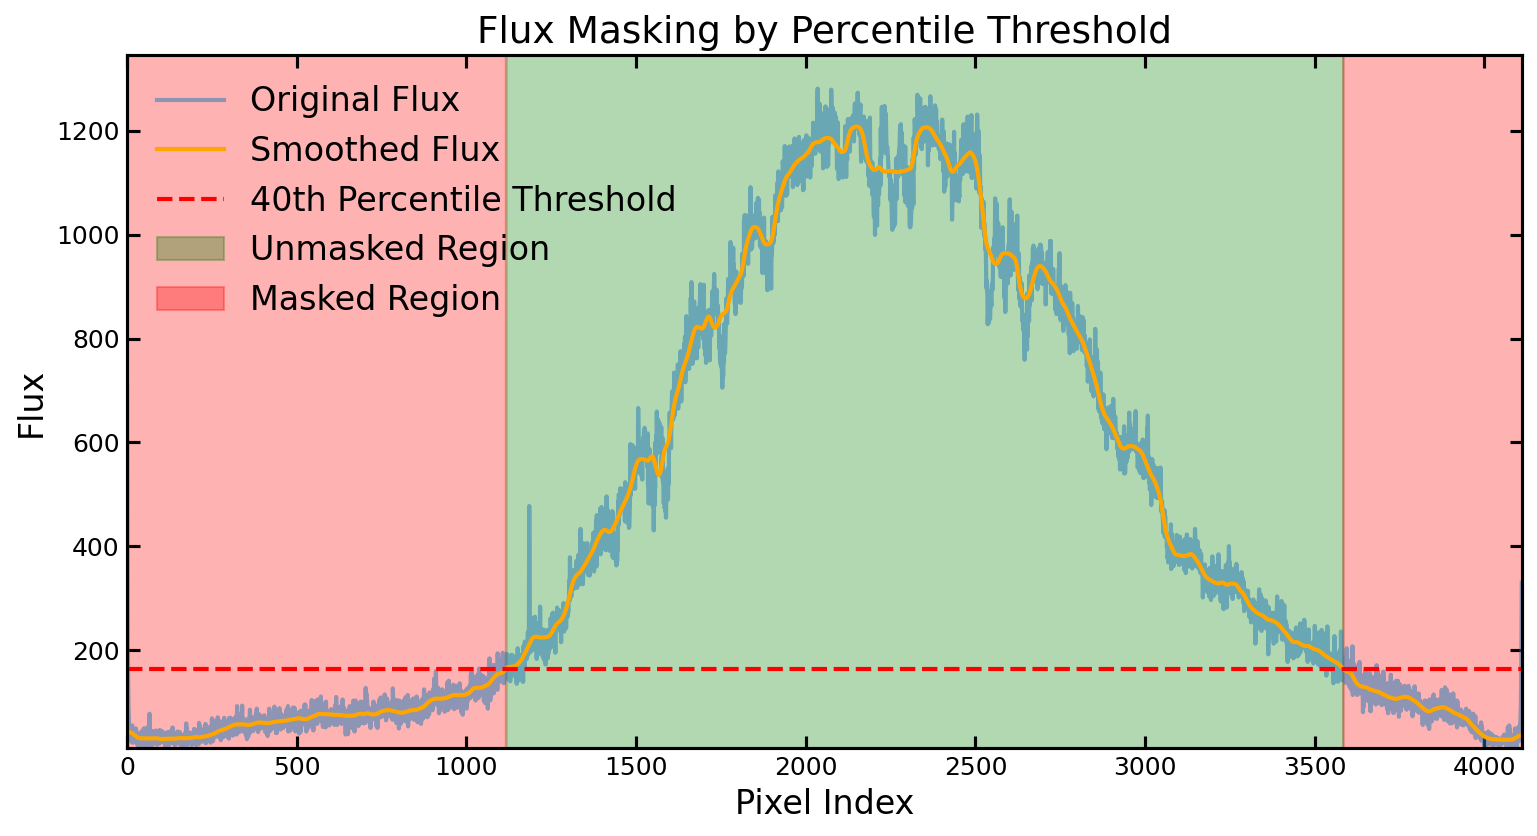

False
Lower threshold at 40th percentile: 152.55700110433168


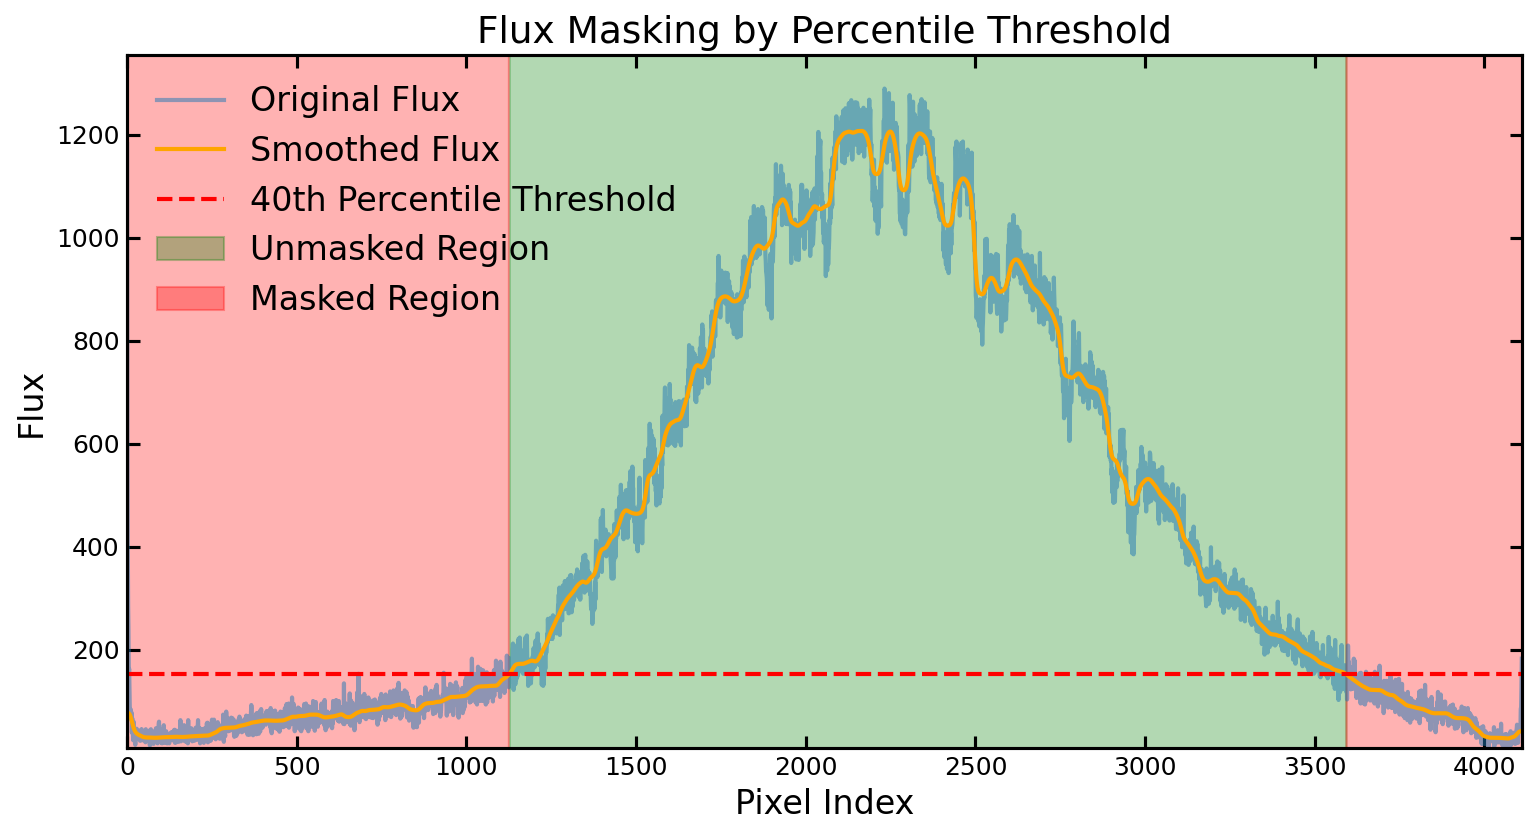

False
Lower threshold at 40th percentile: 141.4275620091852


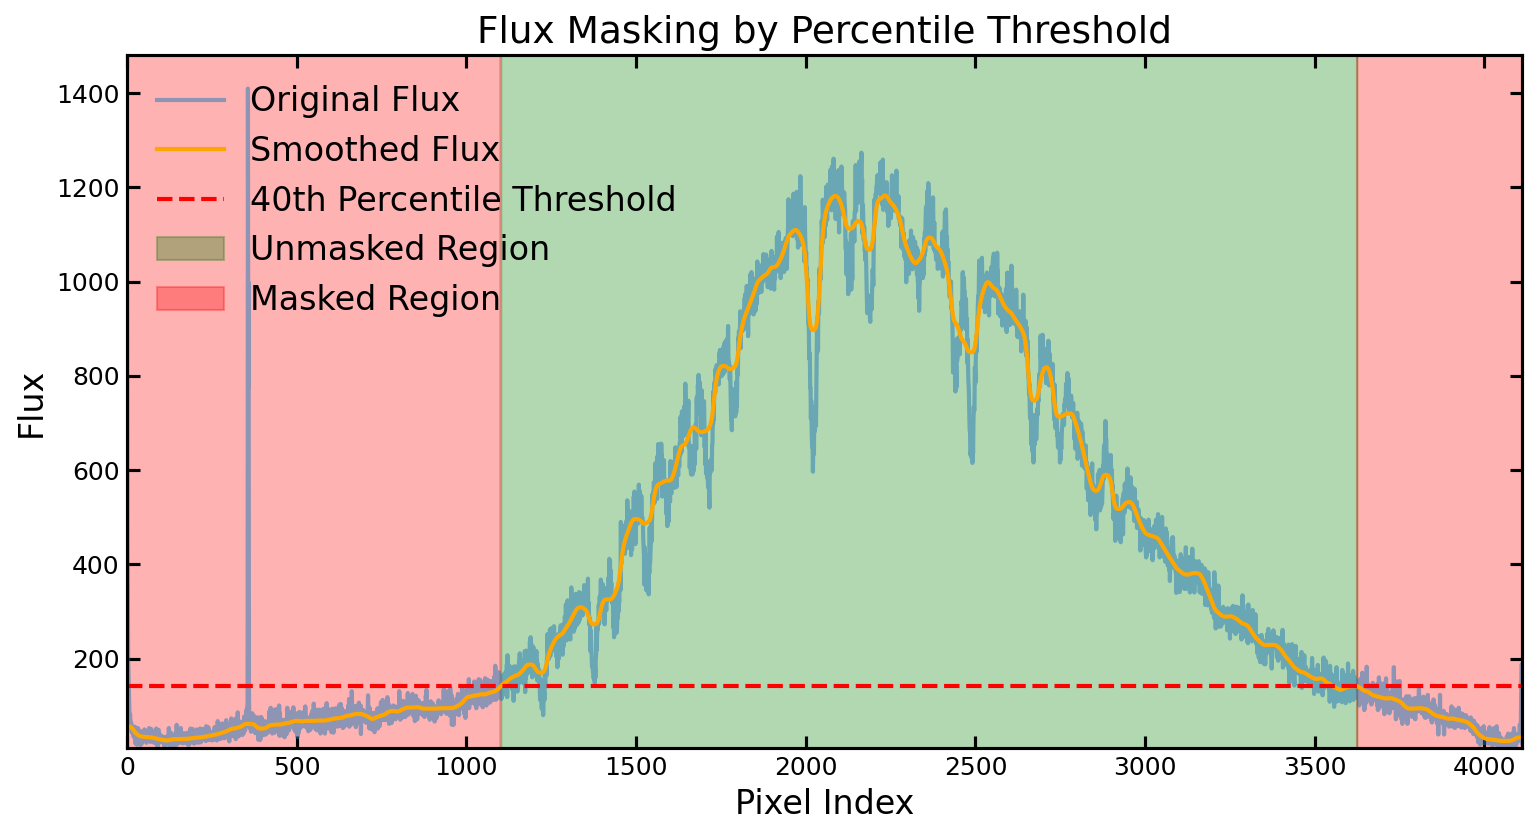

False
Lower threshold at 40th percentile: 143.07374032351964


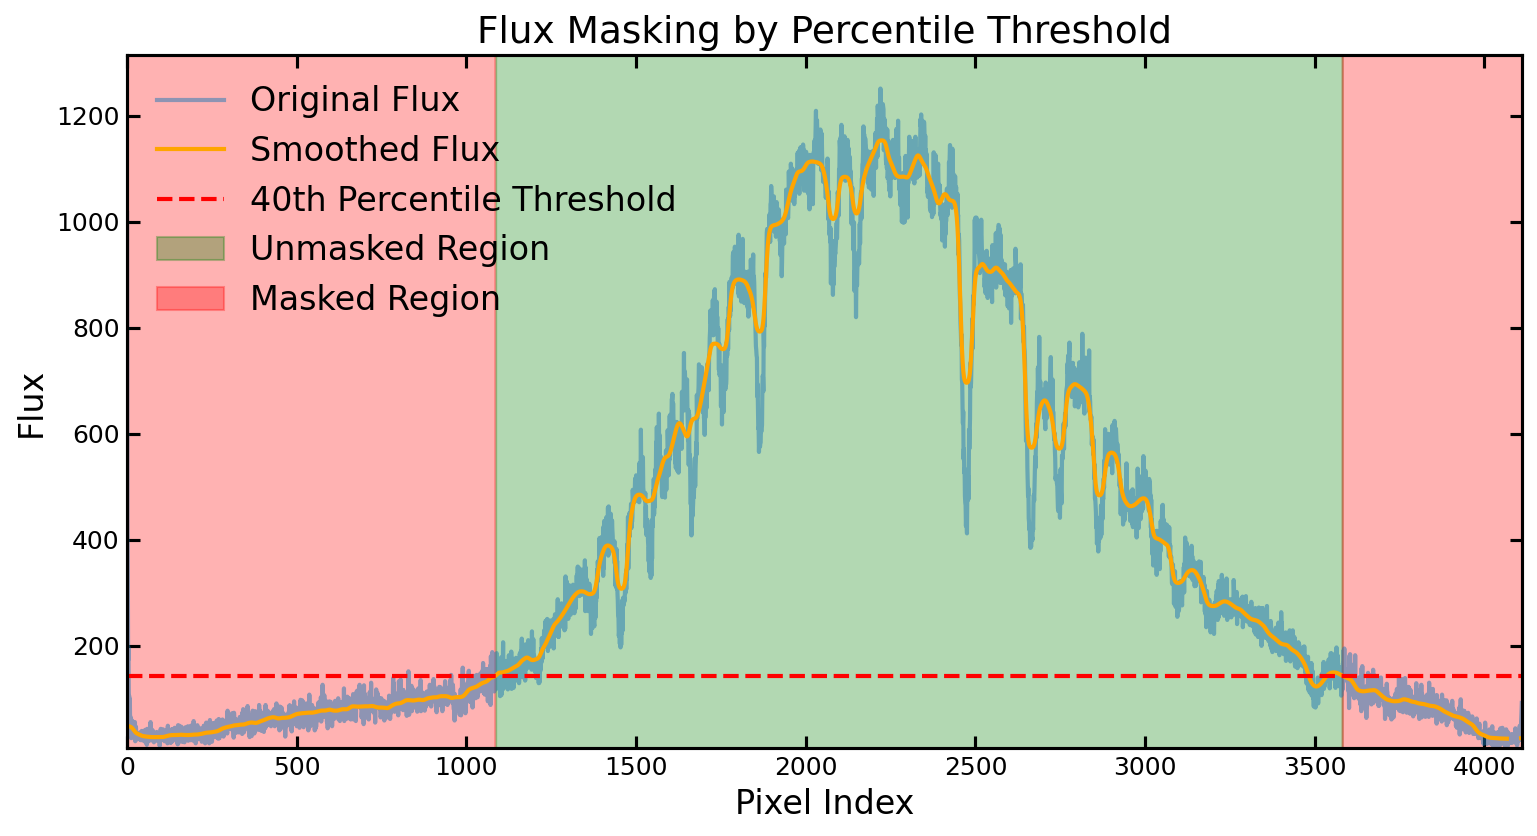

False
Lower threshold at 40th percentile: 133.53362379427824


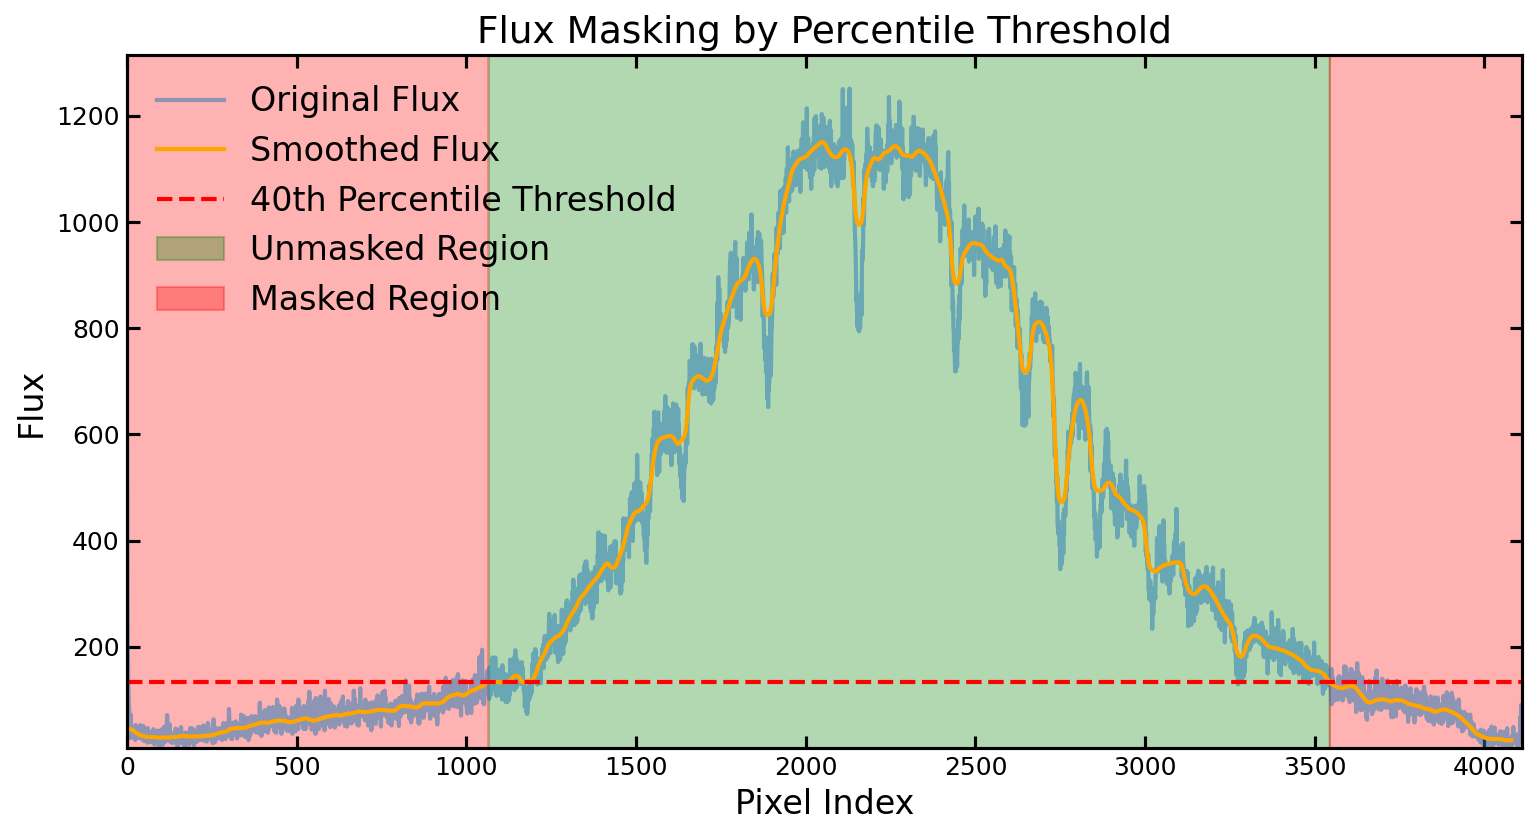

False
Lower threshold at 40th percentile: 128.59760609047083


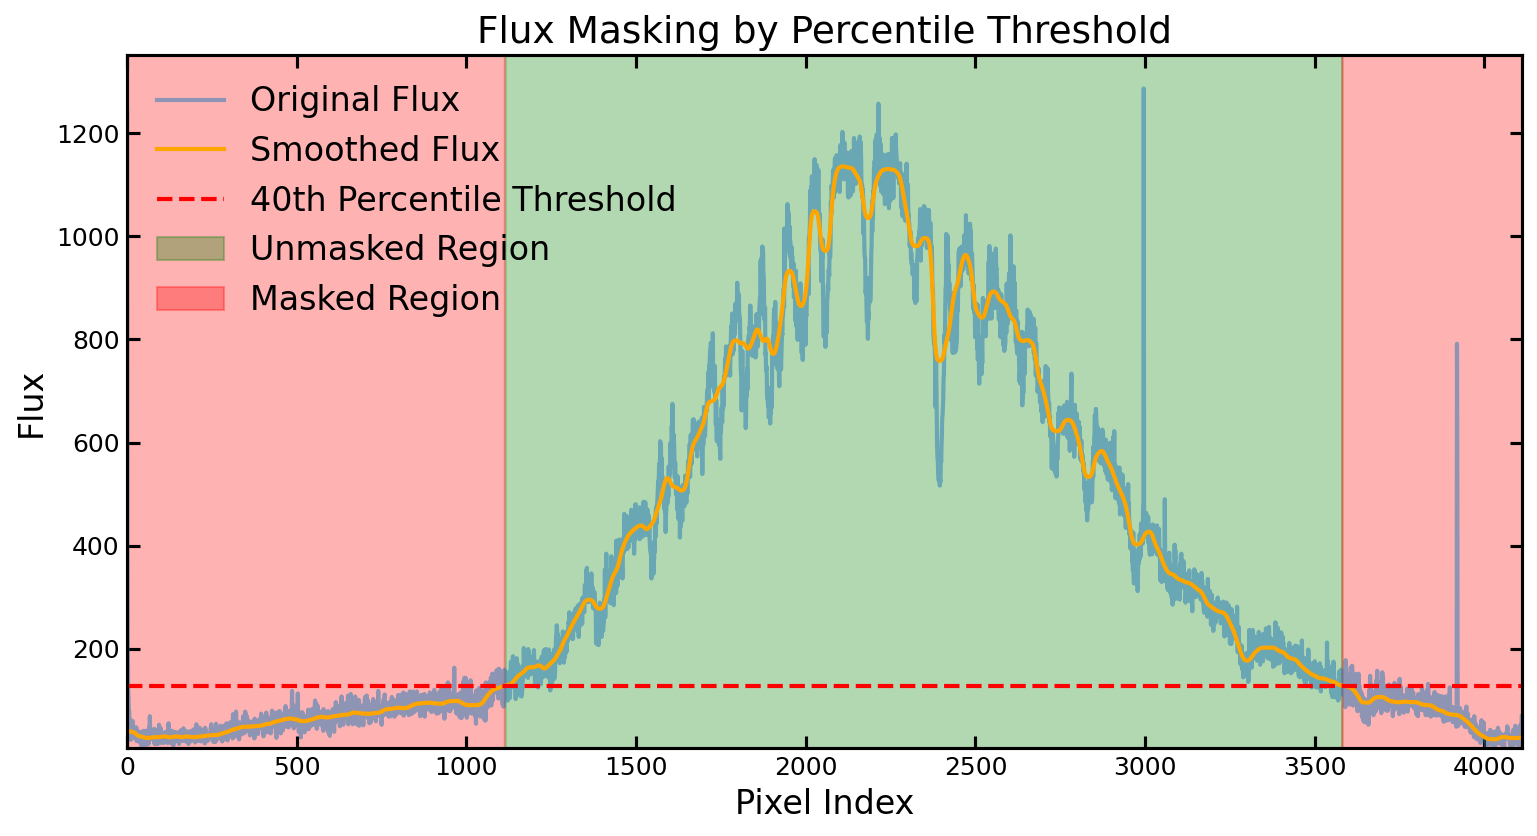

False
Lower threshold at 40th percentile: 120.52638536828509


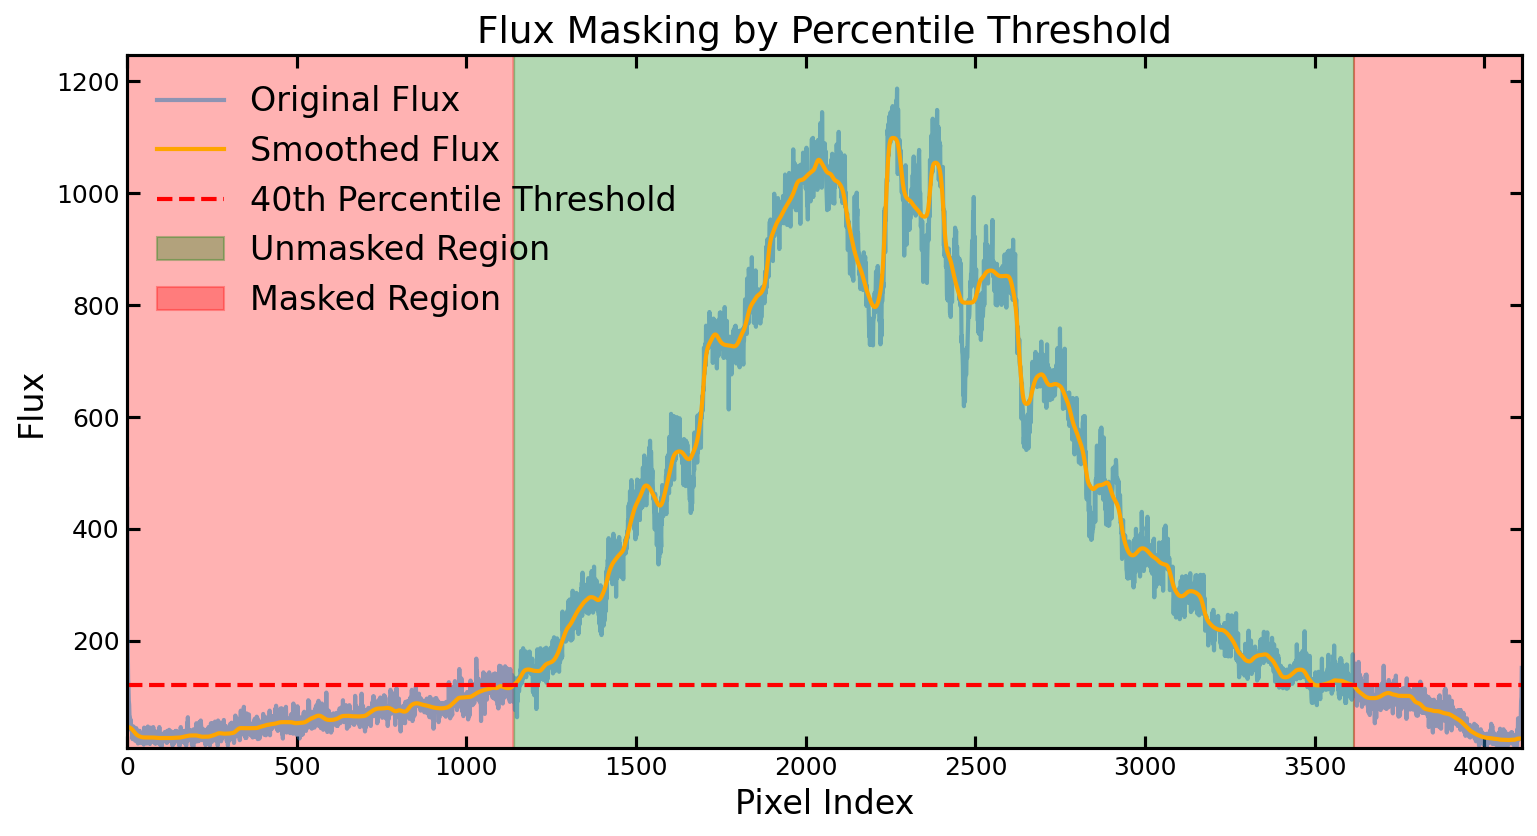

False
Lower threshold at 40th percentile: 93.3937896126339


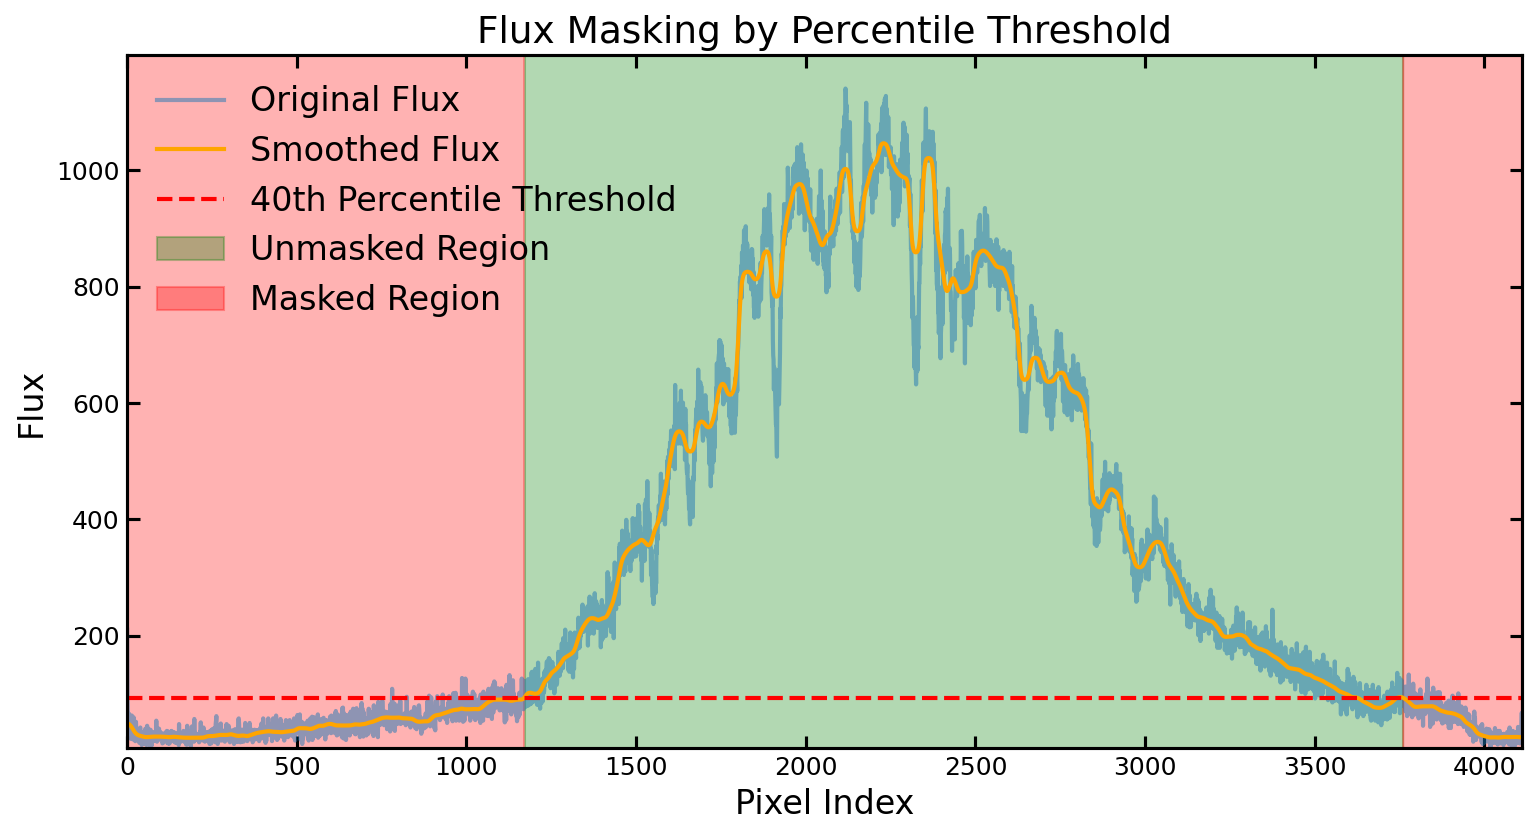

False
Lower threshold at 40th percentile: 68.59741588972288


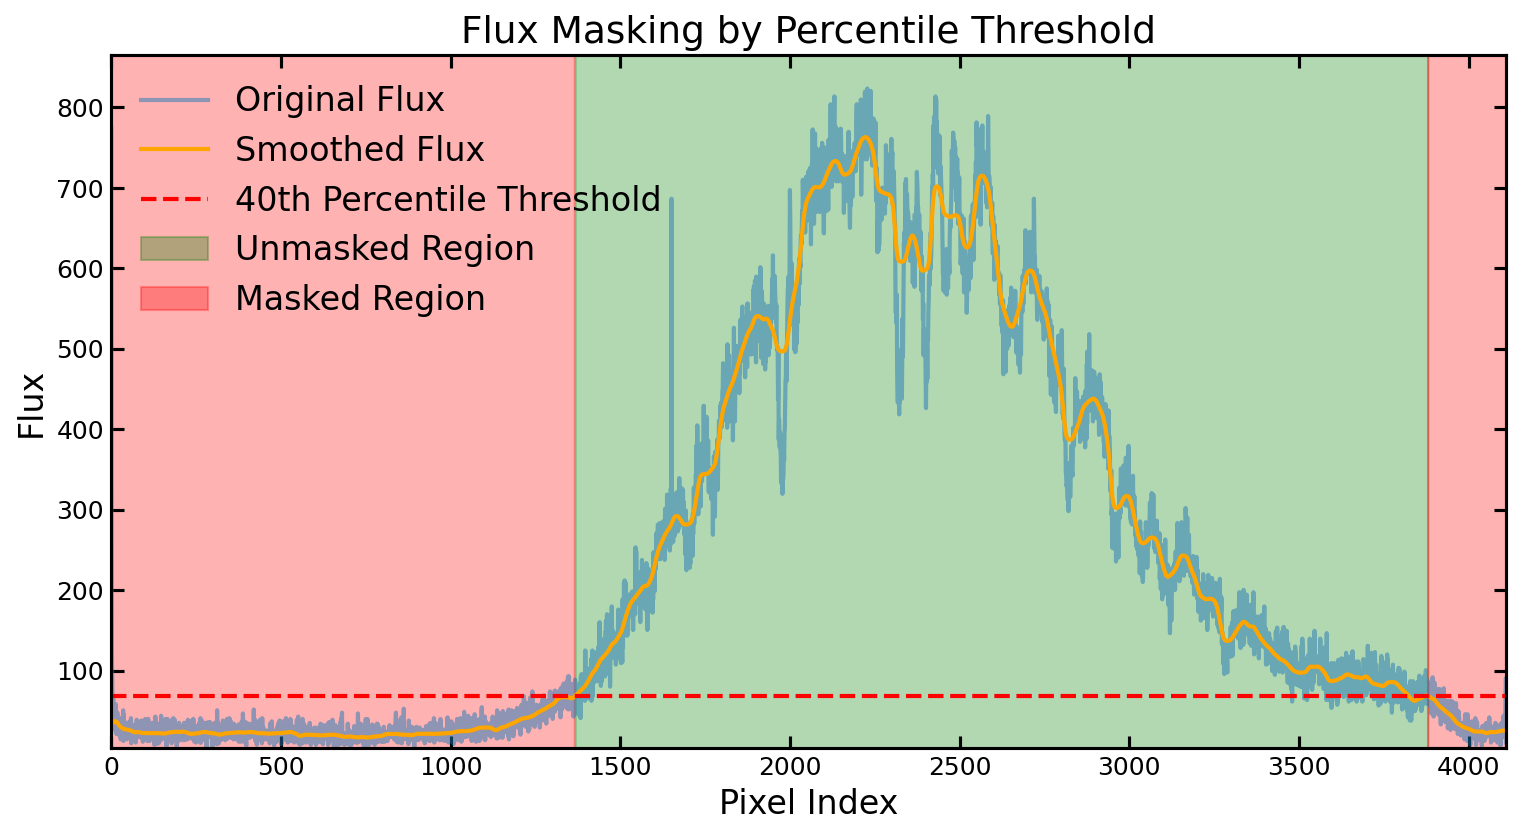

In [74]:
_wave = []
_flux = []
# masks = []
for order in range(len(wave)):
    _mask = mask_order_by_flux_threshold(flux[order], percentile=40, median_window=51, gaussian_window=5, plot=True)
    shift_wave = spectro_tools.shift_spectrum(wave[order], jd, gaia_rv, star_coords, obs_coords)*10
    _flux.append(flux[order][_mask])
    _wave.append(shift_wave[_mask])
wave = _wave
flux = _flux

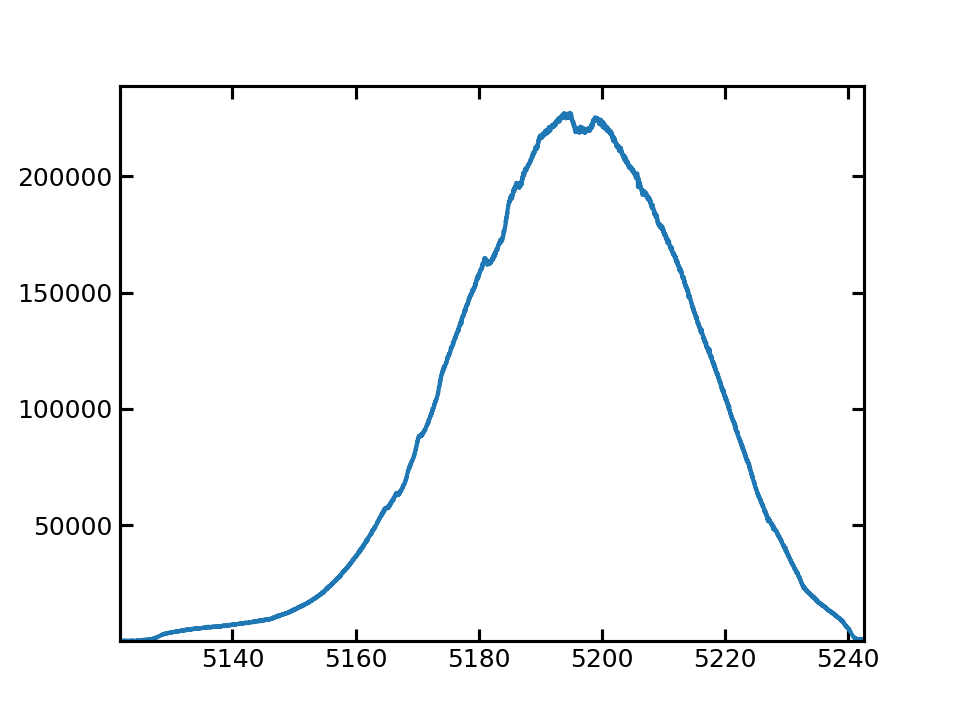

In [33]:
plt.close('all')
order = 15
plt.plot(wave[order], flux[order], label=f'{hdr['object']}')
plt.ylim(0.95*np.nanmin(flux[order]), 1.05*np.nanmax(flux[order]))
plt.xlim(np.nanmin(wave[order]), np.nanmax(wave[order]))
plt.show()

In [44]:
flux[15]

array([783.86759815, 551.82718975, 464.08081682, ..., 905.94059406,
       757.42574257,          nan])

In [34]:
resampled_ref_wave, resampled_ref_flux = interpolate_standard_to_veloce_orders(ref_wave, ref_flux, wave)

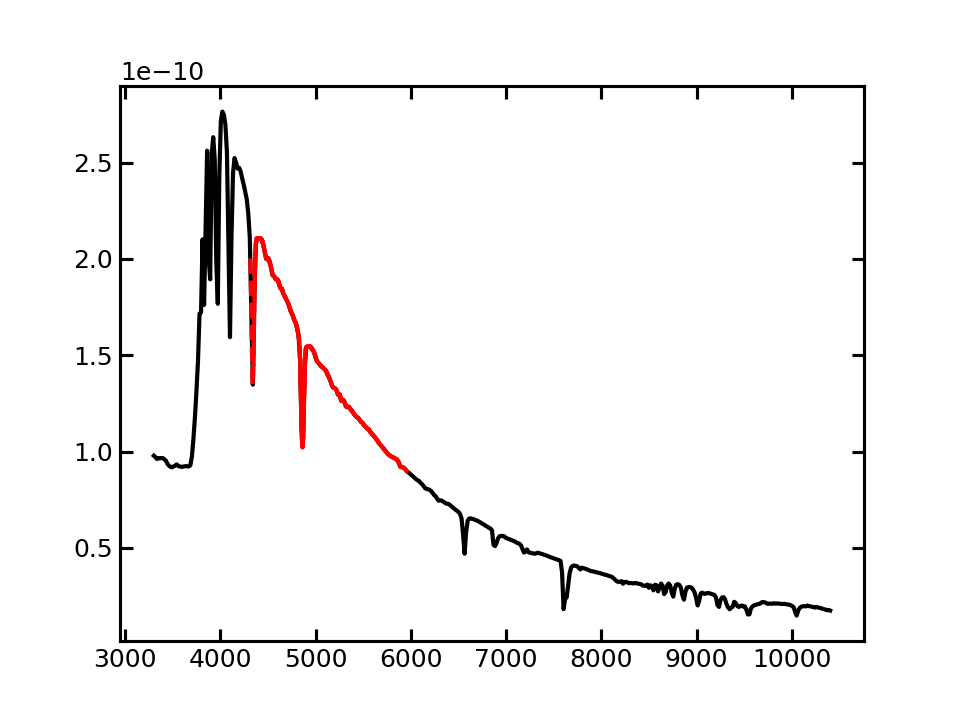

In [35]:
plt.close('all')
plt.plot(ref_wave, ref_flux, 'k-')
for order in range(len(wave)):
    plt.plot(resampled_ref_wave[order], resampled_ref_flux[order], 'r--', label='resampled standard')
# plt.ylim(1.05*ref_flux.max(), 0.95*ref_flux.min())
# plt.xlim(ref_wave.min(), ref_wave.max())
plt.show()